# Computational Complexities and Scalability Tests for `Sphractal`

This notebook contains analysis plots for the strong scaling speedup and weak scaling parallelisation efficiency of the Python package `Sphractal`.

## Notebook setups

In [1]:
from math import ceil, log10
from os import listdir

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from natsort import natsorted
import numpy as np
import pandas as pd
import seaborn as sns

Below are some general settings for plotting figures:

In [2]:
sns.set_context('paper')  # Options are: {paper, notebook, talk, poster}
sns.set_palette('Paired')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
figSize, dpi, fontSize, labelSize = (3.5, 2.5), 300, 'medium', 'small'
legendSize, lineWidth, markerSize = 'x-small', 1, 3
hexCodes = ['#E11845', '#0057E9', '#FF00BD', '#8931EF']

And some specific settings for box plots:

In [3]:
flierprops = dict(marker='x', markerfacecolor='r', markersize=3, markeredgecolor='k', linestyle='none')
boxprops = dict(linestyle='-', linewidth=0.8, edgecolor='k')
whiskerprops = dict(linestyle='-', linewidth=0.5, color='k')
capprops = dict(linestyle='-', linewidth=1.2, color='k')
medianprops = dict(linestyle='--', linewidth=1.2, color='r')
meanprops = dict(marker='s', markerfacecolor='w', markersize=3, markeredgecolor='b', linestyle='none')

## Computational Complexities
Complexity analysis is carried out below for the box-counting algorithms implemented in `Sphractal`.

### Technical Specifications

The computational complexities runs were conducted on 8 cores (1 node) with the machines below:
* a laptop, with the following technical specifications:
  * Operating system: Windows 11 x64
  * CPU model: Intel Core i5-1135G7 @ 2.40GHz, 2419 Mhz
  * CPUs per node: 1
  * cores per CPU: 4
  * total number of logical processors: 8
  * RAM: 4 GB
  * accelerators used (such as GPUs): None
* a high performance computing system, namely [Gadi](https://nci.org.au/our-systems/hpc-systems), hosted at [National Computational Infrastructure](https://nci.org.au/), with the following technical specifications:
  * Operating system: Rocky Linux 8 x86_64
  * CPUs per node: 2 
  * cores per CPU: 24
  * CPU model: Intel Xeon Platinum 8274 (Cascade Lake) 3.2 GHz
  * interconnect: Mellanox HDR 200G InfiniBand in Dragonfly+ network topology 200 Gb/s
  * RAM: 192 GB
  * accelerators used (such as GPUs): None
  * 2 CPU sockets per node, each with 2 NUMA nodes
    * 12 CPU cores per NUMA node
    * 48 GB local RAM per NUMA node
  * 400 GB local SSD disk per node

### Settings

The durations recorded were averaged over 30 runs.

### Abbreviations

* EX = exact surface representation
* VX = voxelised point cloud surface representation
* TC = time complexity
* SS = strong scaling
* WS = weak scaling
* LAP = laptop
* HPC = high performance computing cluster

### General Functions

In [4]:
def getAllDurations(targetDir, keyword):
    allDurationFiles = [fname for fname in listdir(targetDir) if keyword in fname and '.swp' not in fname]
    allDurations = []
    for fname in natsorted(allDurationFiles):
        print(fname)
        with open(f"{targetDir}/{fname}", 'r') as f:
            durations = []
            for line in f:
                if 'Run ' in line:
                    durations.append(float(line.strip().split()[-2]))
        allDurations.append(durations)
    return allDurations

In [5]:
def getAllDBoxes(targetDir, keyword):
    allDurationFiles = [fname for fname in listdir(targetDir) if keyword in fname and '.swp' not in fname]
    dBoxes, upCIs, lowCIs, r2s = [], [], [], []
    for fname in natsorted(allDurationFiles):
        print(fname)
        with open(f"{targetDir}/{fname}", 'r') as f:
            for line in f:
                if 'D_Box' in line:
                    dBox =  float(line.strip().split()[3])
                    upCI = float(line.strip().split()[4].replace('[', '').replace(',', ''))
                    lowCI = float(line.strip().split()[5].replace(']', '').replace(',', ''))
                    r2 = float(line.strip().split()[-1])
                    break
        dBoxes.append(dBox)
        upCIs.append(upCI)
        lowCIs.append(lowCI)
        r2s.append(r2)
    return dBoxes, upCIs, lowCIs, r2s

In [6]:
def initBoxPlots(df, xLabel, surfType, analysisType, machine=''):
    rowNum, colNum = 2, ceil(len(df.columns) / 2)
    fig, ax = plt.subplots(rowNum, colNum, figsize=(1.5 * colNum, 5), dpi=dpi)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    row = 0
    for (i, colName) in enumerate(df.columns):
        col = i - row*colNum
        if col >= colNum: 
            row += 1
            col -= colNum
        sns.boxplot(data=df[colName], ax=ax[row, col], width=0.8, showfliers=True, linewidth=1.2, 
                    color=sns.color_palette('Paired', rowNum * colNum)[i], 
                    showmeans=True, meanline=False, notch=False,
                    flierprops=flierprops, boxprops=boxprops, whiskerprops=whiskerprops, 
                    capprops=capprops, medianprops=medianprops, meanprops=meanprops)
        ax[row, col].set_xlabel(colName, fontdict={'weight': 'bold', 'fontsize': 'medium'})
        ax[row, col].set_xticklabels([])
        ax[row, col].tick_params(axis='y', labelsize='small')
    fig.text(0.5, -0.01, xLabel, ha='center', va='center', fontsize='large')
    fig.text(-0.01, 0.5, 'Duration (s)', ha='center', va='center', rotation='vertical', fontsize='large')
    plt.tight_layout()
    plt.savefig(f"{analysisType}_{surfType}_{machine}BoxPlots.png", bbox_inches='tight')

In [7]:
def initBoxPlotsShareY(df, xLabel, surfType, analysisType, machine=''):
    fig = plt.figure(figsize=figSize, dpi=dpi)
    ax = fig.add_subplot(1, 1, 1)
    sns.boxplot(data=df, orient='v', palette='Paired', ax=ax, width=0.7, 
                showfliers=True, flierprops={'marker': 'x', 'markerfacecolor': 'k', 'markersize': 2, 
                                             'linestyle': 'none'}, linewidth=0.8)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.set_xlabel(xLabel, fontsize=labelSize)
    ax.set_ylabel('Duration (s)', fontsize=labelSize)
    # ax.set_title(f"{surfType} {analysisType} Durations")
    plt.tight_layout()
    plt.savefig(f"{analysisType}_{surfType}_{machine}BoxPlotsShareY.png")

In [8]:
def rmOutliers(df, unit):
    durations = []
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1  # Interquartile range
        durationNoOutlier = df[col].loc[(df[col] >= q1 - 1.5*iqr) & (df[col] <= q3 + 1.5*iqr)]
        print(f"{col} {unit}(s)\t: Retained {len(durationNoFlier)} out of {len(df)} samples")
        durations.append(durationNoOutlier.mean())
    return durations

### Box-Counting Dimensions

In [9]:
dBoxes, upCIs, lowCIs, r2s = getAllDBoxes('runtimes/computationalComplexity', 'vxhpc')
dBoxes

vxhpc10
vxhpc14
vxhpc17
vxhpc20
vxhpc27
vxhpc31
vxhpc38
vxhpc49
vxhpc61
vxhpc77
vxhpc98
vxhpc123


[1.8669,
 1.9154,
 2.0922,
 2.1509,
 2.2068,
 2.2443,
 2.247,
 2.2561,
 2.2212,
 2.2796,
 2.2717,
 2.1912]

### Time Complexity

#### Voxelised Point Cloud Surface Representation

##### Load Data into Dataframes

In [10]:
TC_VX_HPC_NAtomsIdeal = (43, 86, 172, 344, 688, 1032, 2064, 4128, 8256, 16512, 33024, 66048)
TC_VX_HPC_Natoms = (43, 87, 177, 321, 683, 1055, 1961, 4189, 8007, 16187, 33573, 66283)
TC_VX_HPC_nsatoms = (30, 44, 108, 158, 254, 377, 534, 923, 1438, 2303, 3858, 6016)
TC_VX_HPC_Diameters = (10, 14, 17, 20, 27, 31, 38, 49, 61, 77, 98, 123)  # Angstroms

TC_VX_HPC_AllDurations = getAllDurations('runtimes/computationalComplexity', 'vxhpc')
TC_VX_HPC_DurationsDF = pd.DataFrame(np.array(TC_VX_HPC_AllDurations).T, columns=TC_VX_HPC_Natoms)
TC_VX_HPC_DurationsDF.head()

vxhpc10
vxhpc14
vxhpc17
vxhpc20
vxhpc27
vxhpc31
vxhpc38
vxhpc49
vxhpc61
vxhpc77
vxhpc98
vxhpc123


,43,87,177,321,683,1055,1961,4189,8007,16187,33573,66283
0,3.9204,4.1084,4.4447,4.3625,4.8134,5.3303,6.4058,10.2880,23.6476,71.6439,285.9620,1299.4906
1,3.9055,4.1238,4.1807,4.3901,4.8405,5.2401,6.2833,10.1249,23.3406,70.7609,277.8897,1255.1148
2,3.9234,4.1260,4.3699,4.5119,4.7068,5.3346,6.4047,10.2372,24.0373,70.4493,284.0934,1254.4351
3,3.9005,4.1745,4.2064,4.4674,4.5848,5.3632,6.3933,10.2530,23.0428,72.1793,279.8735,1252.9101
4,3.8985,4.0965,4.2085,4.4919,4.5962,5.2238,6.2842,10.1990,23.7195,71.0841,276.9694,1257.2879


In [11]:
TC_VX_LAP_NAtomsIdeal = TC_VX_HPC_NAtomsIdeal[:10]
TC_VX_LAP_Natoms = TC_VX_HPC_Natoms[:10]
TC_VX_LAP_nsatoms = TC_VX_HPC_nsatoms[:10]
TC_VX_LAP_Diameters = (10, 14, 17, 20, 27, 31, 38, 49, 61, 77, 98, 123)[:10]  # Angstroms

TC_VX_LAP_AllDurations = getAllDurations('runtimes/computationalComplexity', 'vxlap')

TC_VX_LAP_DurationsDF = pd.DataFrame(np.array(TC_VX_LAP_AllDurations).T, columns=TC_VX_LAP_Natoms) 
TC_VX_LAP_DurationsDF.head()

vxlap10
vxlap14
vxlap17
vxlap20
vxlap27
vxlap31
vxlap38
vxlap49
vxlap61
vxlap77


,43,87,177,321,683,1055,1961,4189,8007,16187
0,8.1807,10.0856,8.8689,8.1690,8.1777,9.9745,11.1583,15.0475,25.2623,77.8793
1,6.9594,7.5254,7.1539,8.1077,7.9112,9.0639,11.1833,13.7593,24.8531,76.8979
2,7.3853,6.6950,7.7251,7.8761,8.6933,9.5005,12.0360,14.9668,25.2941,77.4708
3,7.6602,9.6152,7.8448,7.5184,8.6642,8.1931,11.8164,14.3053,27.8158,82.2469
4,6.9415,6.9971,7.2619,7.2913,7.5192,9.0962,12.1335,16.2742,26.8421,76.9789


##### Visualise via Box Plots

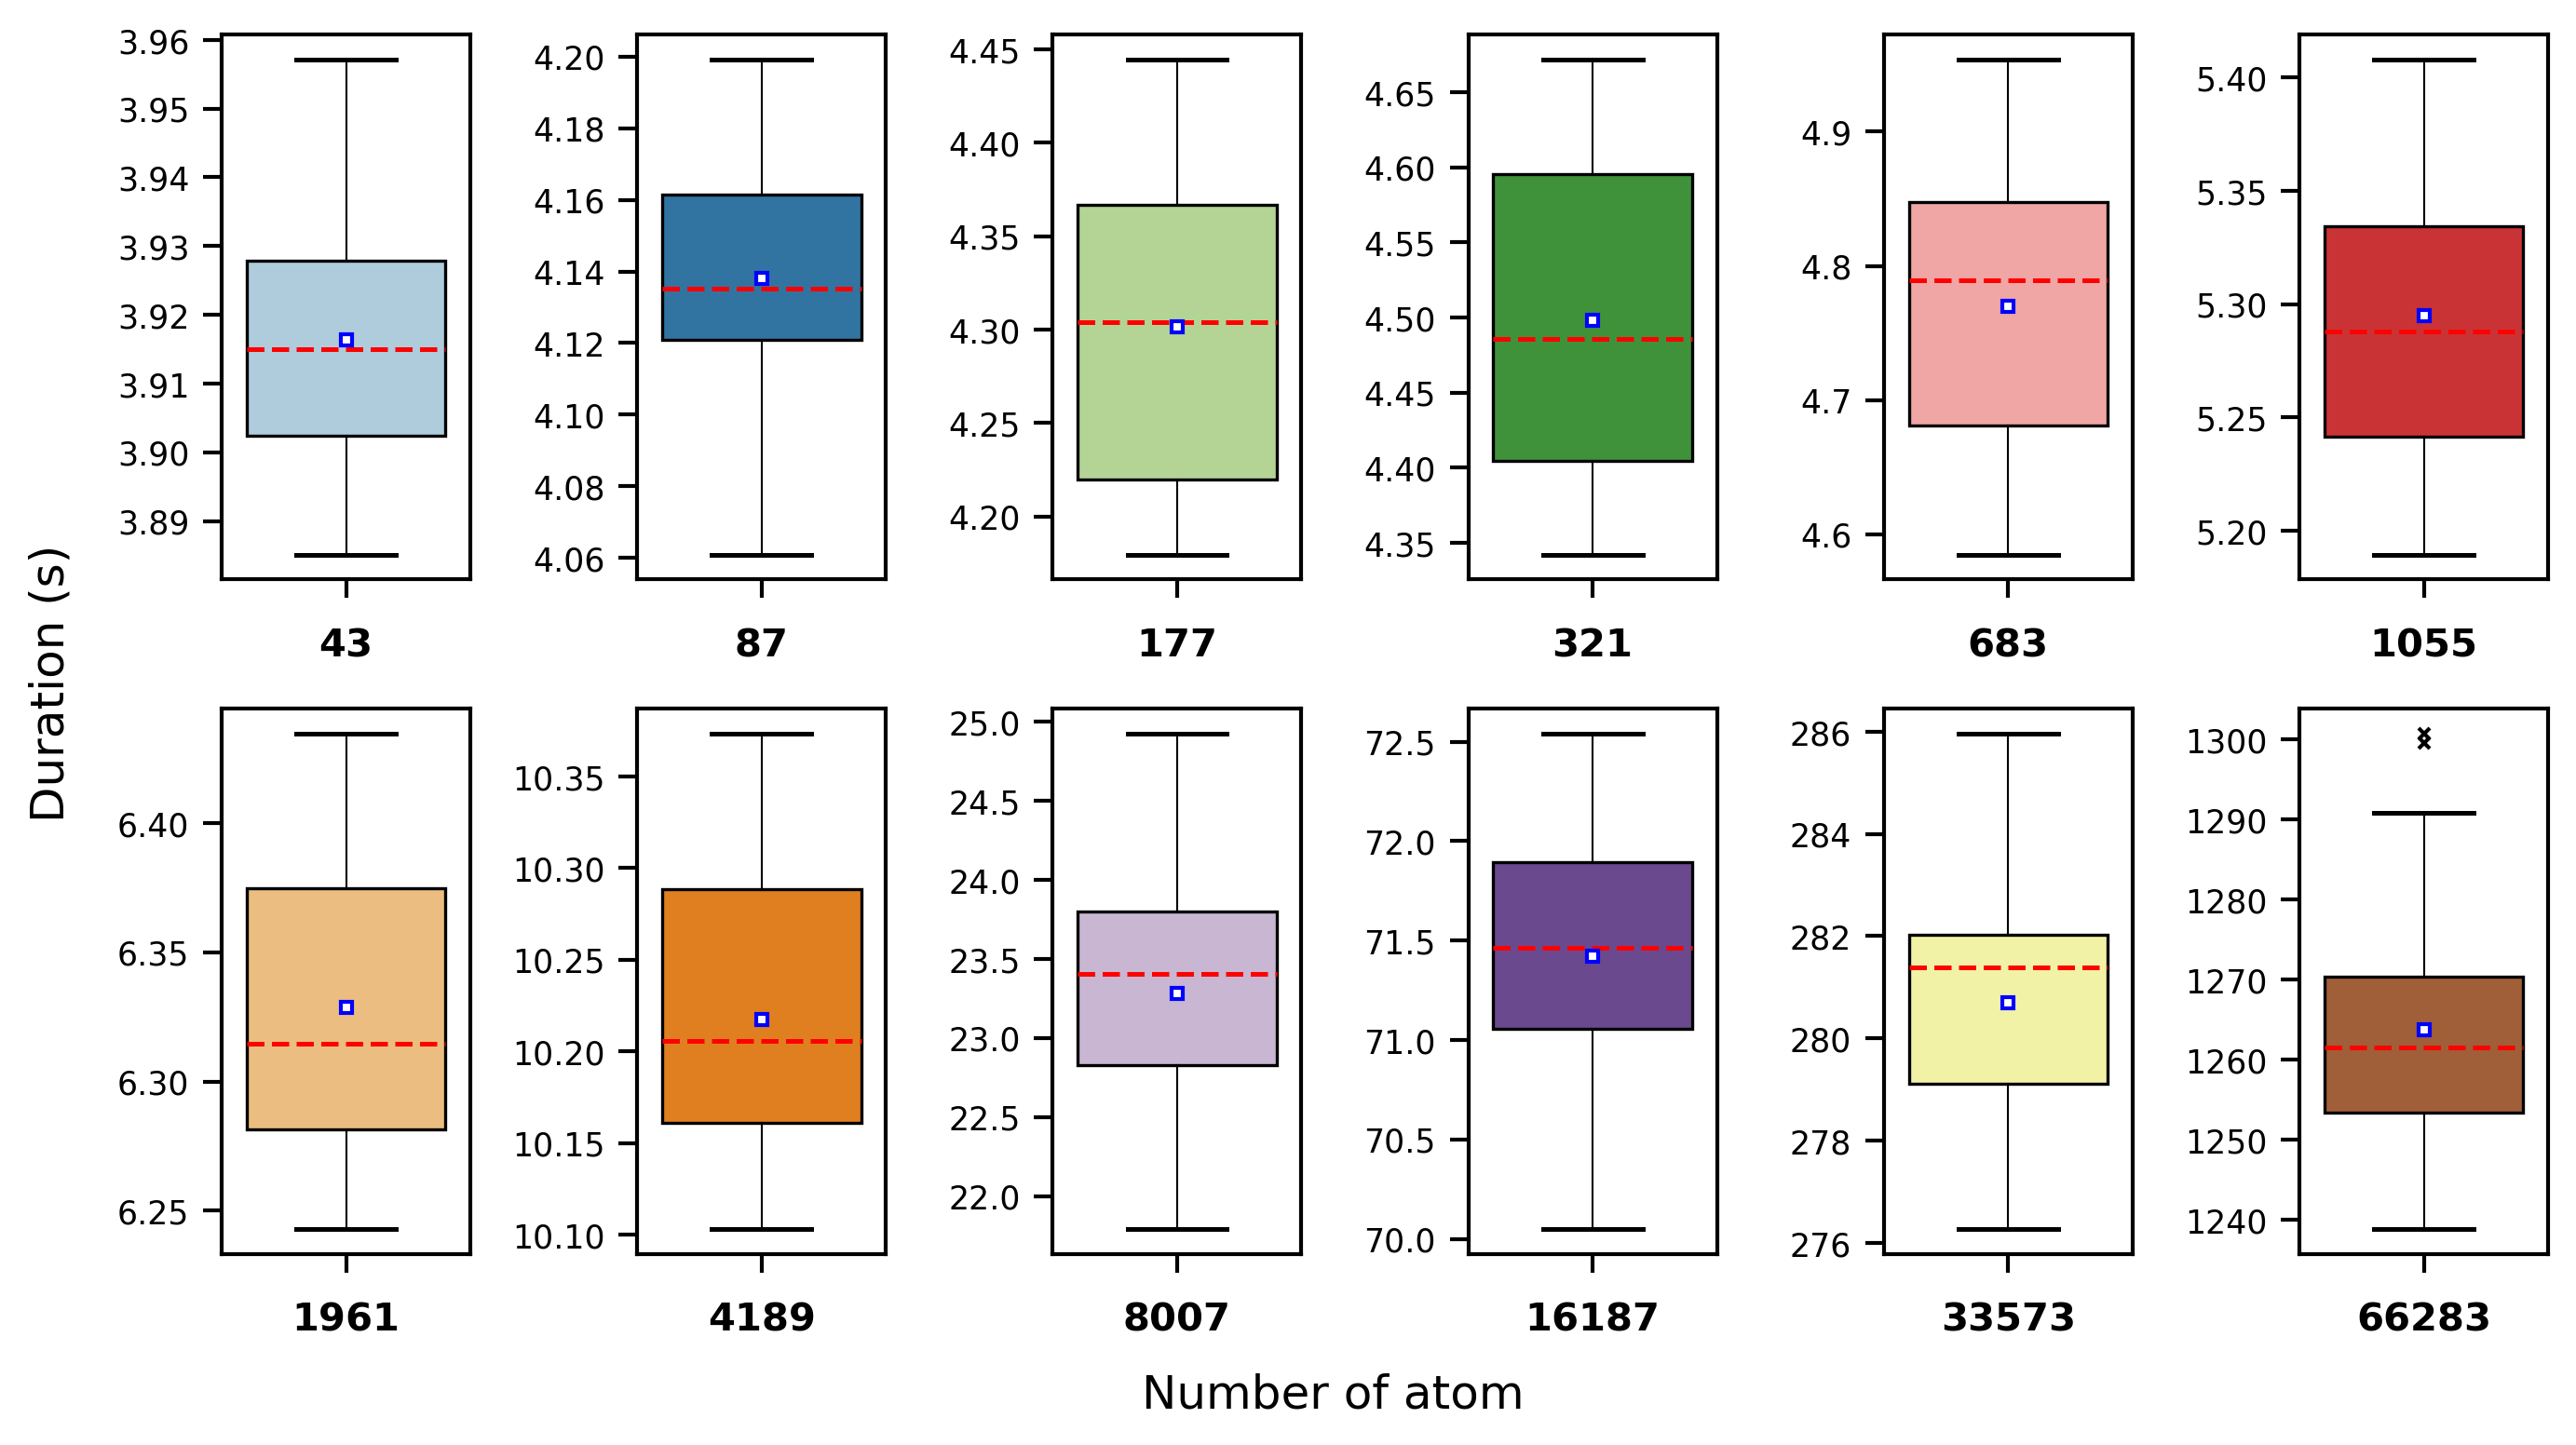

In [12]:
initBoxPlots(TC_VX_HPC_DurationsDF, 'Number of atom', 'VX', 'TC', 'HPC_')

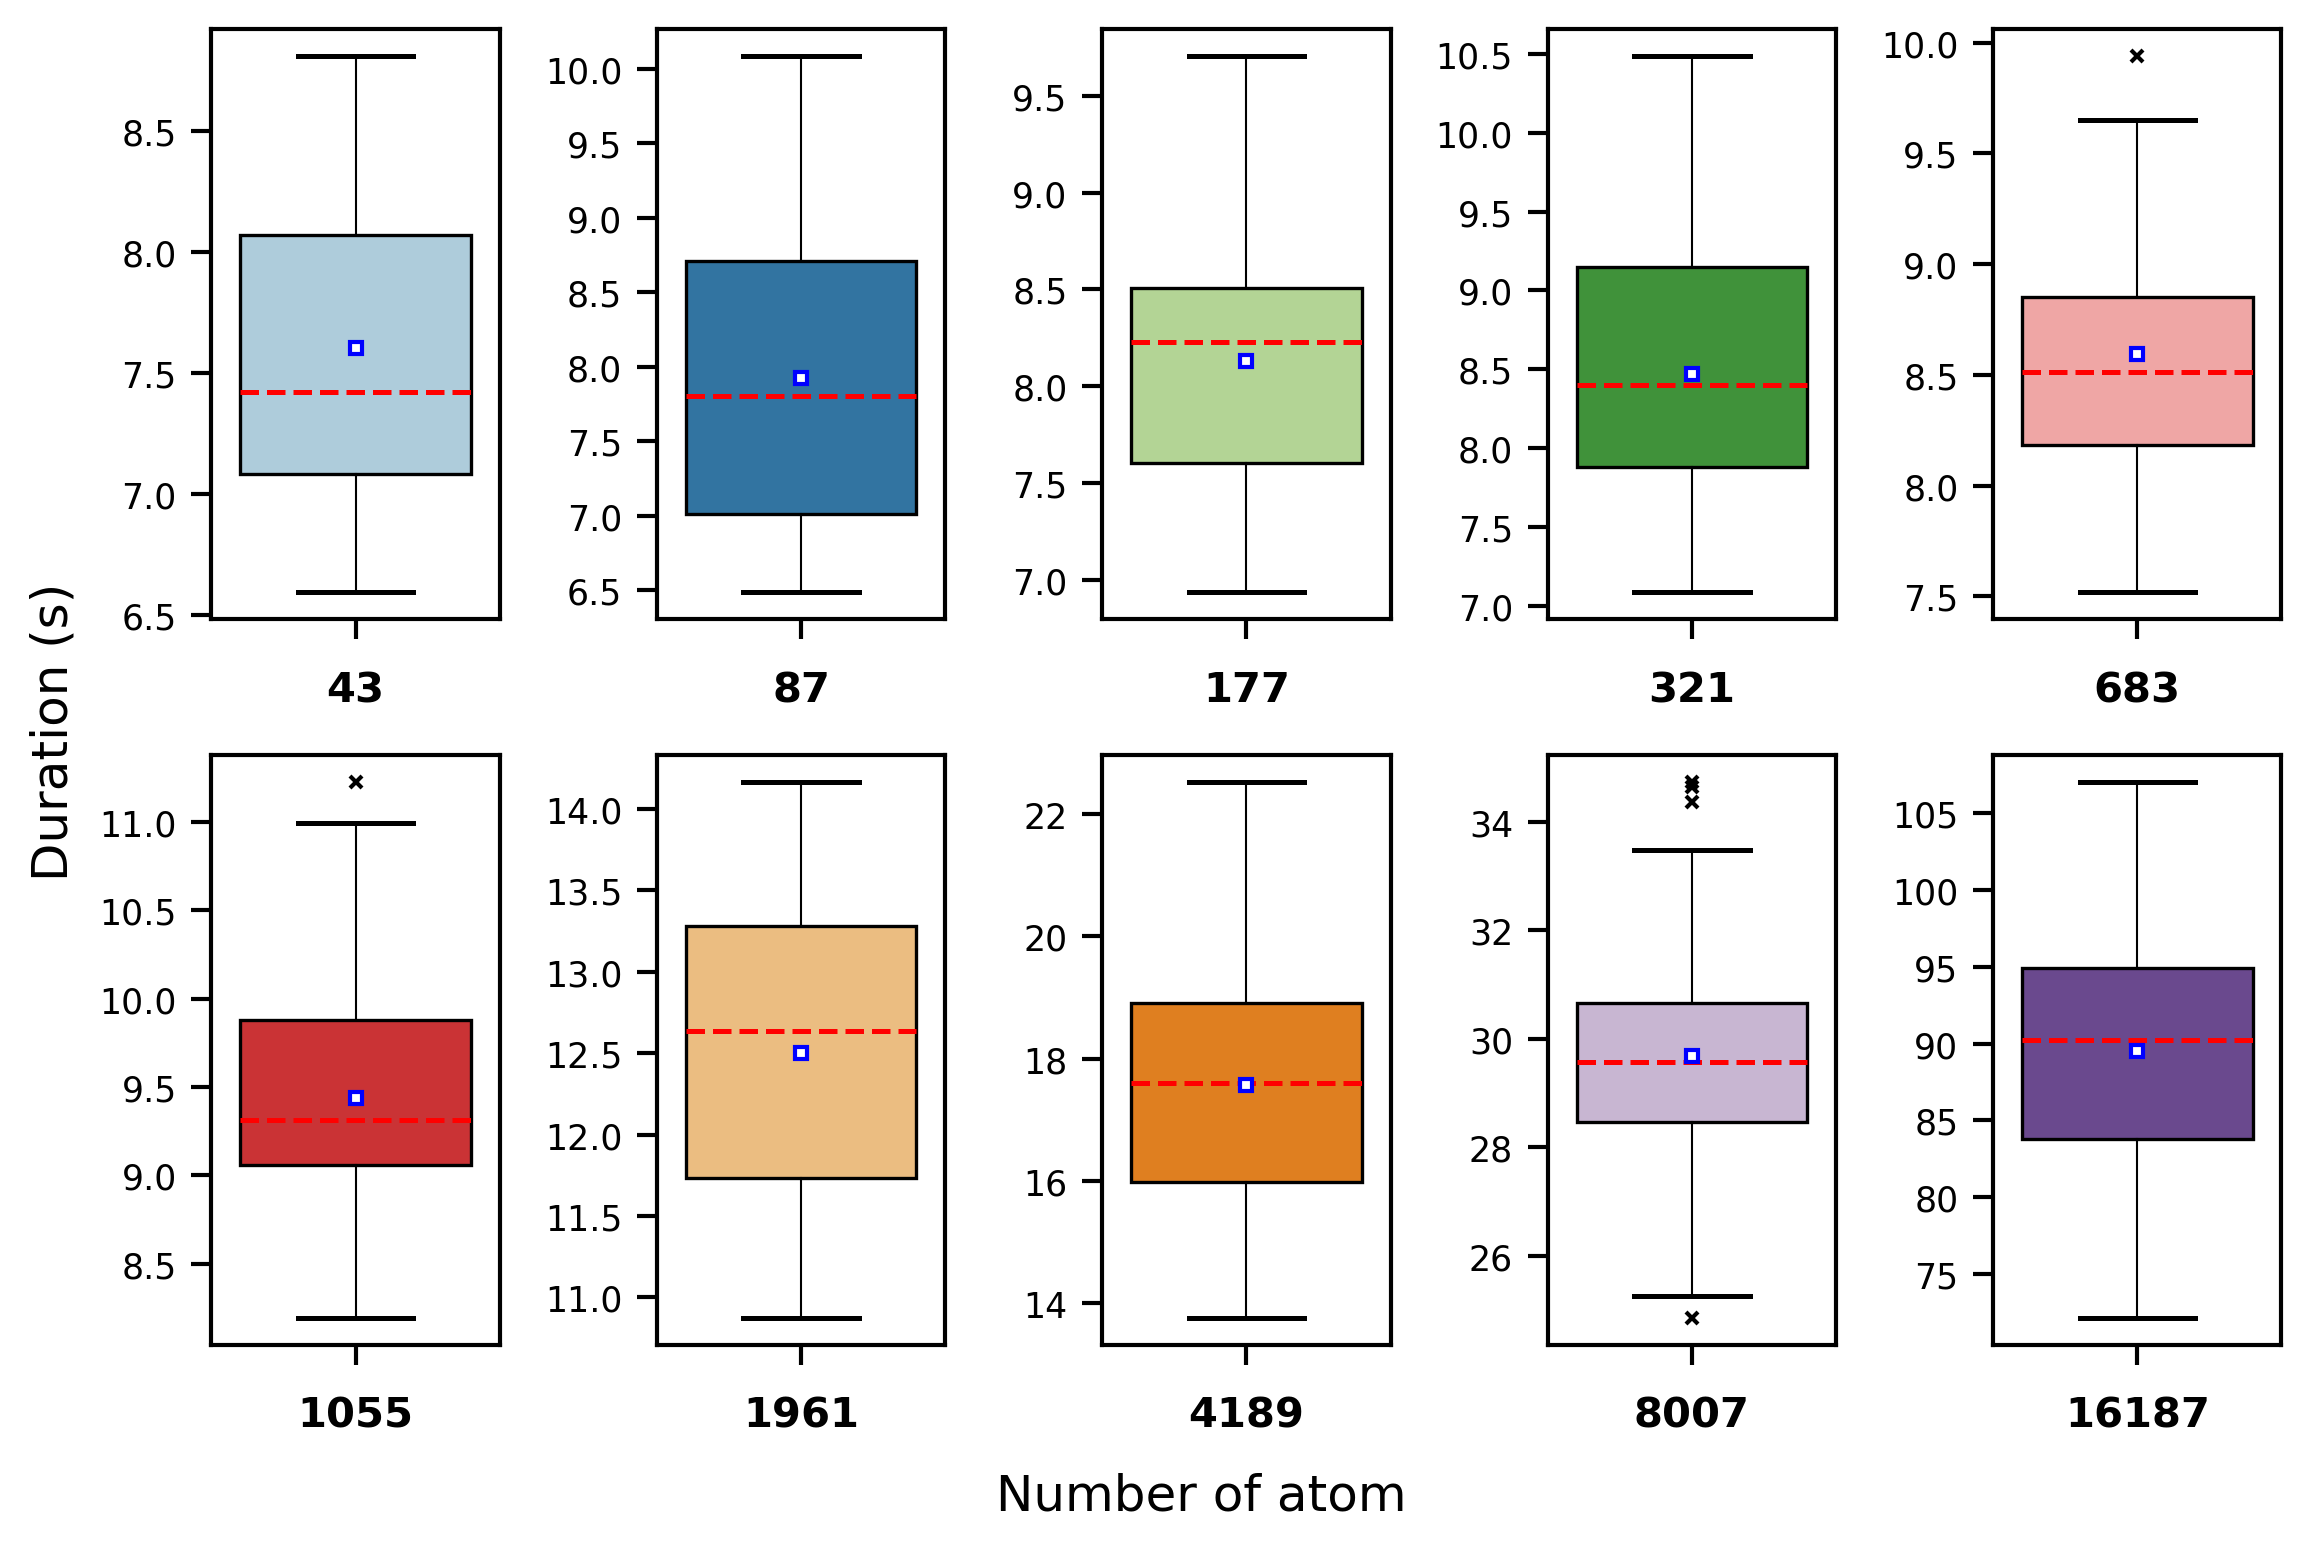

In [13]:
initBoxPlots(TC_VX_LAP_DurationsDF, 'Number of atom', 'VX', 'TC', 'LAP_')

##### Remove Outliers

In [14]:
TC_VX_HPC_Durations = []
for col in TC_VX_HPC_DurationsDF.columns:
    q1 = TC_VX_HPC_DurationsDF[col].quantile(0.25)
    q3 = TC_VX_HPC_DurationsDF[col].quantile(0.75)
    iqr = q3 - q1  # Interquartile range
    durationNoFlier = TC_VX_HPC_DurationsDF[col].loc[(TC_VX_HPC_DurationsDF[col] >= q1 - 1.5*iqr) & 
                                                     (TC_VX_HPC_DurationsDF[col] <= q3 + 1.5*iqr)]
    print(f"{col} atoms(s)\t: Retained {len(durationNoFlier)} out of 30 samples")
    TC_VX_HPC_Durations.append(durationNoFlier.mean())

43 atoms(s)	: Retained 30 out of 30 samples
87 atoms(s)	: Retained 30 out of 30 samples
177 atoms(s)	: Retained 30 out of 30 samples
321 atoms(s)	: Retained 30 out of 30 samples
683 atoms(s)	: Retained 30 out of 30 samples
1055 atoms(s)	: Retained 30 out of 30 samples
1961 atoms(s)	: Retained 30 out of 30 samples
4189 atoms(s)	: Retained 30 out of 30 samples
8007 atoms(s)	: Retained 30 out of 30 samples
16187 atoms(s)	: Retained 30 out of 30 samples
33573 atoms(s)	: Retained 30 out of 30 samples
66283 atoms(s)	: Retained 28 out of 30 samples


In [15]:
TC_VX_LAP_Durations = []
for col in TC_VX_LAP_DurationsDF.columns:
    q1 = TC_VX_LAP_DurationsDF[col].quantile(0.25)
    q3 = TC_VX_LAP_DurationsDF[col].quantile(0.75)
    iqr = q3 - q1  # Interquartile range
    durationNoFlier = TC_VX_LAP_DurationsDF[col].loc[(TC_VX_LAP_DurationsDF[col] >= q1 - 1.5*iqr) & 
                                                     (TC_VX_LAP_DurationsDF[col] <= q3 + 1.5*iqr)]
    print(f"{col} atoms(s)\t: Retained {len(durationNoFlier)} out of 30 samples")
    TC_VX_LAP_Durations.append(durationNoFlier.mean())

43 atoms(s)	: Retained 30 out of 30 samples
87 atoms(s)	: Retained 30 out of 30 samples
177 atoms(s)	: Retained 30 out of 30 samples
321 atoms(s)	: Retained 30 out of 30 samples
683 atoms(s)	: Retained 29 out of 30 samples
1055 atoms(s)	: Retained 29 out of 30 samples
1961 atoms(s)	: Retained 30 out of 30 samples
4189 atoms(s)	: Retained 30 out of 30 samples
8007 atoms(s)	: Retained 26 out of 30 samples
16187 atoms(s)	: Retained 30 out of 30 samples


##### Visualise Time Complexity Plots

In [16]:
TC_VX_HPC_DF = pd.DataFrame({'natom': TC_VX_HPC_Natoms, 'nsatom': TC_VX_HPC_nsatoms, 
                             'diameter': TC_VX_HPC_Diameters, 'duration': TC_VX_HPC_Durations})
TC_VX_HPC_DF.head()

,natom,nsatom,diameter,duration
0,43,30,10,3.916377
1,87,44,14,4.137997
2,177,108,17,4.301320
3,321,158,20,4.498127
4,683,254,27,4.770057


In [17]:
TC_VX_LAP_DF = pd.DataFrame({'natom': TC_VX_LAP_Natoms, 'nsatom': TC_VX_LAP_nsatoms, 
                             'diameter': TC_VX_LAP_Diameters, 'duration': TC_VX_LAP_Durations})
TC_VX_LAP_DF.head()

,natom,nsatom,diameter,duration
0,43,30,10,7.601370
1,87,44,14,7.923577
2,177,108,17,8.128823
3,321,158,20,8.468650
4,683,254,27,8.545790


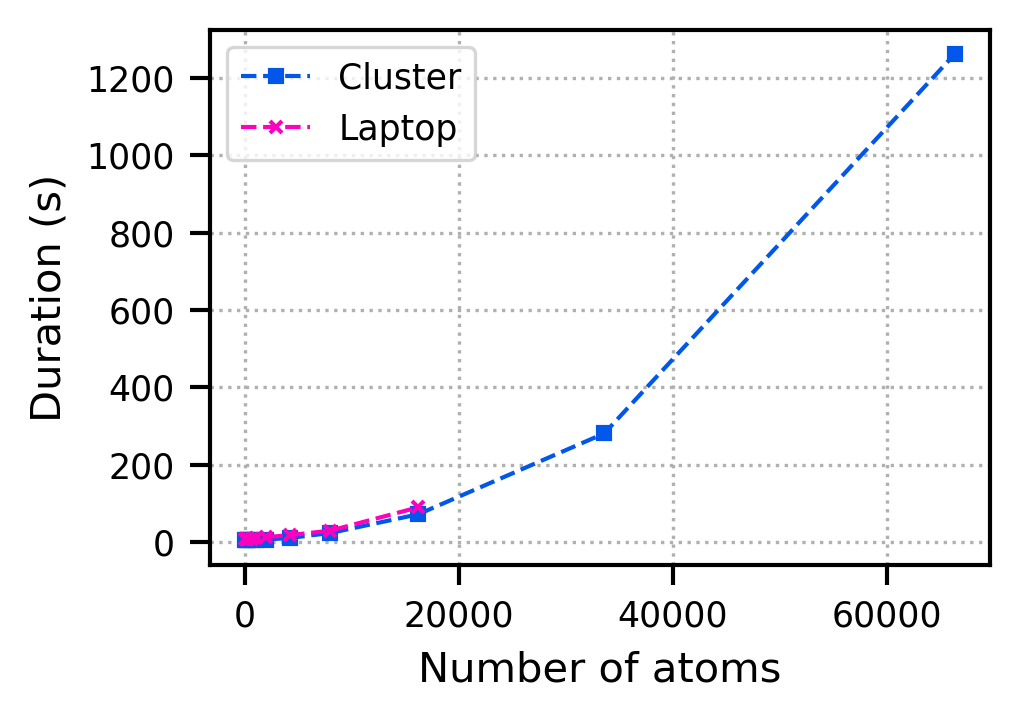

In [18]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(TC_VX_HPC_DF['natom'], TC_VX_HPC_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(TC_VX_LAP_DF['natom'], TC_VX_LAP_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='x', markersize=markerSize, color=hexCodes[2], zorder=3)
ax.set_xlabel('Number of atoms', fontsize='medium')
ax.set_ylabel('Duration (s)', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Cluster', 'Laptop'), fontsize='small')
plt.tight_layout()
plt.savefig('TC_VX_HPCvsLAP.png')

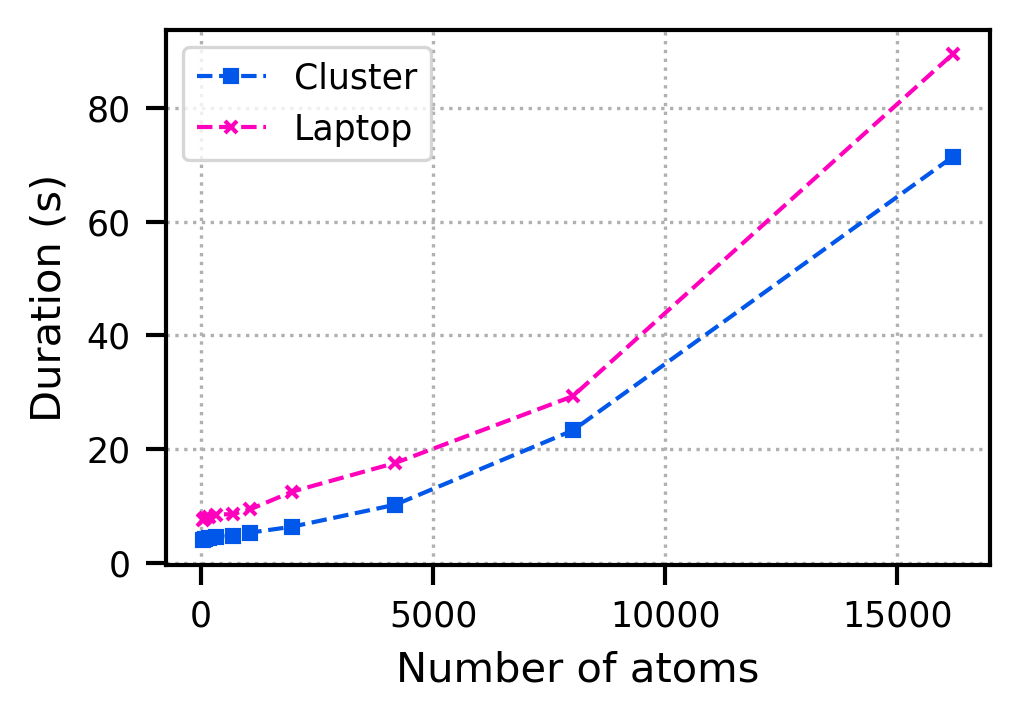

In [19]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(TC_VX_HPC_DF['natom'][:10], TC_VX_HPC_DF['duration'][:10], 
        linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(TC_VX_LAP_DF['natom'], TC_VX_LAP_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='x', markersize=markerSize, color=hexCodes[2], zorder=3)
ax.set_xlabel('Number of atoms', fontsize='medium')
ax.set_ylabel('Duration (s)', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Cluster', 'Laptop'), fontsize='small')
plt.tight_layout()
plt.savefig('TC_VX_HPCvsLAP_SysErr.png')

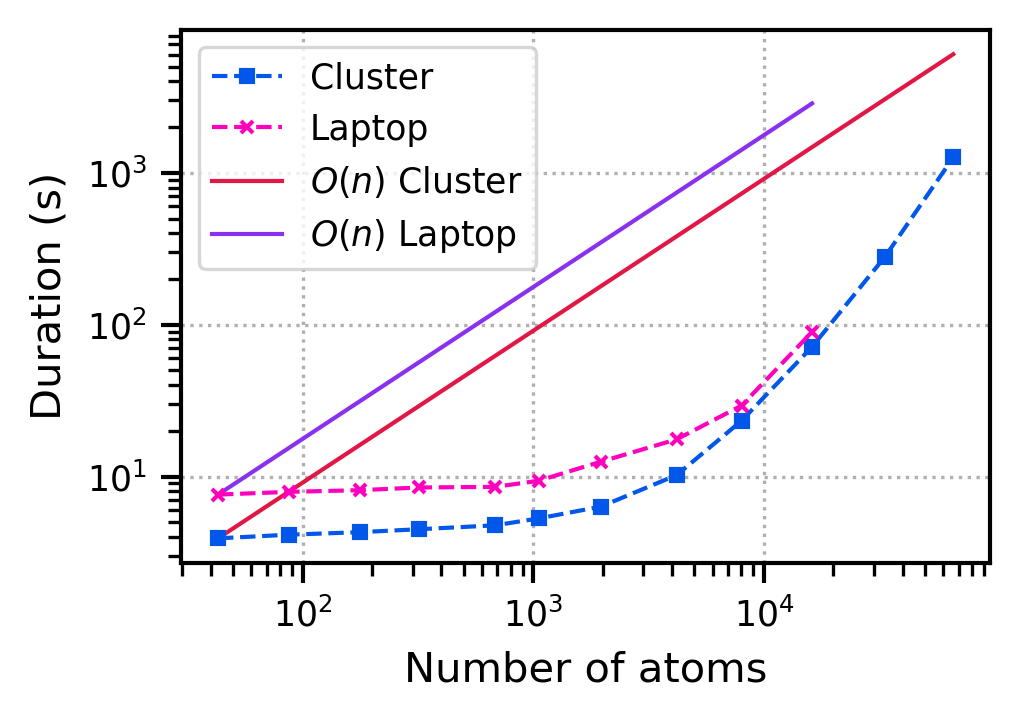

In [20]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(TC_VX_HPC_DF['natom'], TC_VX_HPC_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(TC_VX_LAP_DF['natom'], TC_VX_LAP_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='x', markersize=markerSize, color=hexCodes[2], zorder=3)
ax.plot(TC_VX_HPC_DF['natom'], TC_VX_HPC_DF['duration'][0] * (TC_VX_HPC_DF['natom'] / TC_VX_HPC_DF['natom'][0]), 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, 
        color=hexCodes[0], zorder=2)
ax.plot(TC_VX_LAP_DF['natom'], TC_VX_LAP_DF['duration'][0] * (TC_VX_LAP_DF['natom'] / TC_VX_LAP_DF['natom'][0]), 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, 
        color=hexCodes[3], zorder=2)
ax.loglog()
ax.set_xlabel('Number of atoms', fontsize='medium')
ax.set_ylabel('Duration (s)', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Cluster', 'Laptop', r'$O(n)$ Cluster', r'$O(n)$ Laptop'), fontsize='small')
plt.tight_layout()
plt.savefig('TC_VX_HPCvsLAP_loglog.png')

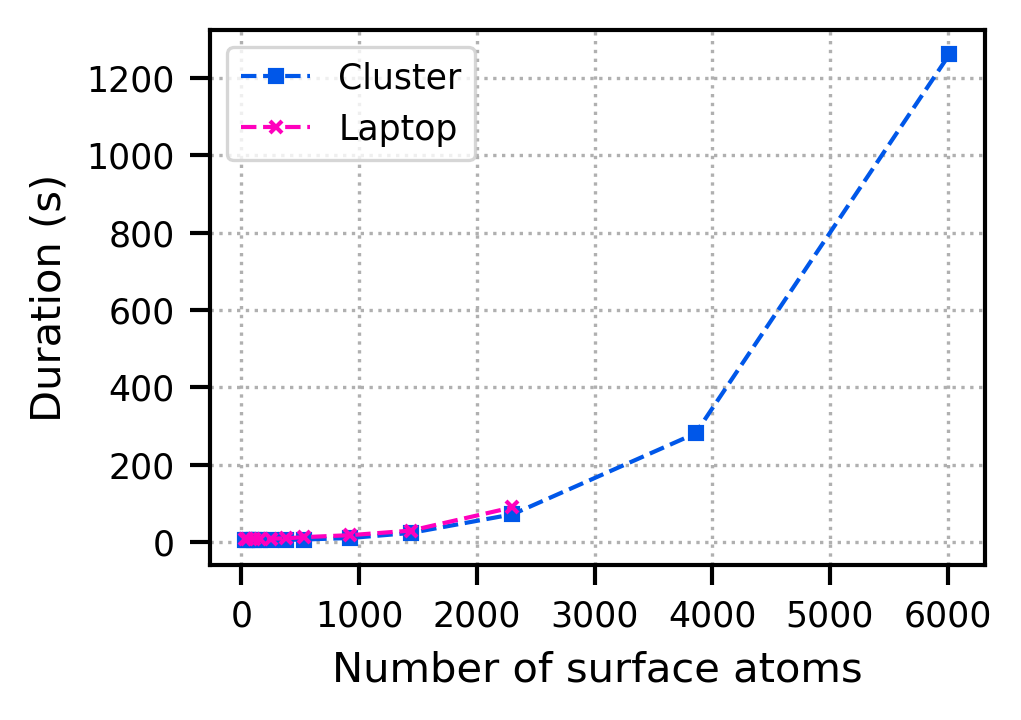

In [21]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(TC_VX_HPC_DF['nsatom'], TC_VX_HPC_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(TC_VX_LAP_DF['nsatom'], TC_VX_LAP_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='x', markersize=markerSize, color=hexCodes[2], zorder=3)
# ax.loglog()
ax.set_xlabel('Number of surface atoms', fontsize='medium')
ax.set_ylabel('Duration (s)', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Cluster', 'Laptop'), fontsize='small')
plt.tight_layout()
plt.savefig('TC_VX_HPCvsLAP_satom.png')

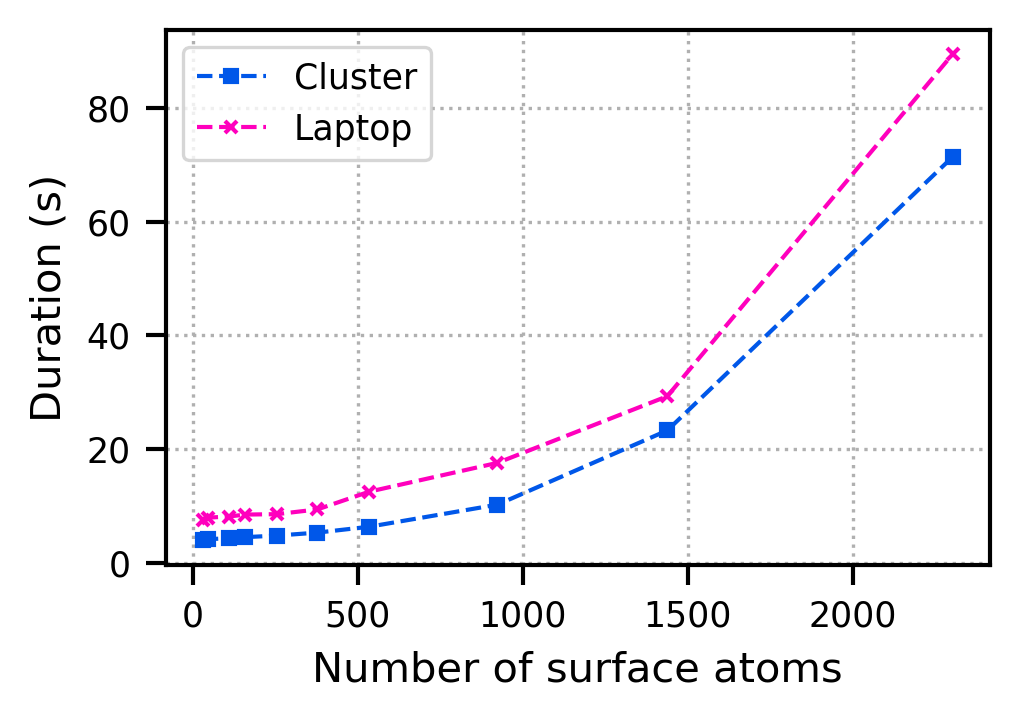

In [22]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(TC_VX_HPC_DF['nsatom'][:10], TC_VX_HPC_DF['duration'][:10], 
        linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(TC_VX_LAP_DF['nsatom'], TC_VX_LAP_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='x', markersize=markerSize, color=hexCodes[2], zorder=3)
ax.set_xlabel('Number of surface atoms', fontsize='medium')
ax.set_ylabel('Duration (s)', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Cluster', 'Laptop'), fontsize='small')
plt.tight_layout()
plt.savefig('TC_VX_HPCvsLAP_SysErr_satom.png')

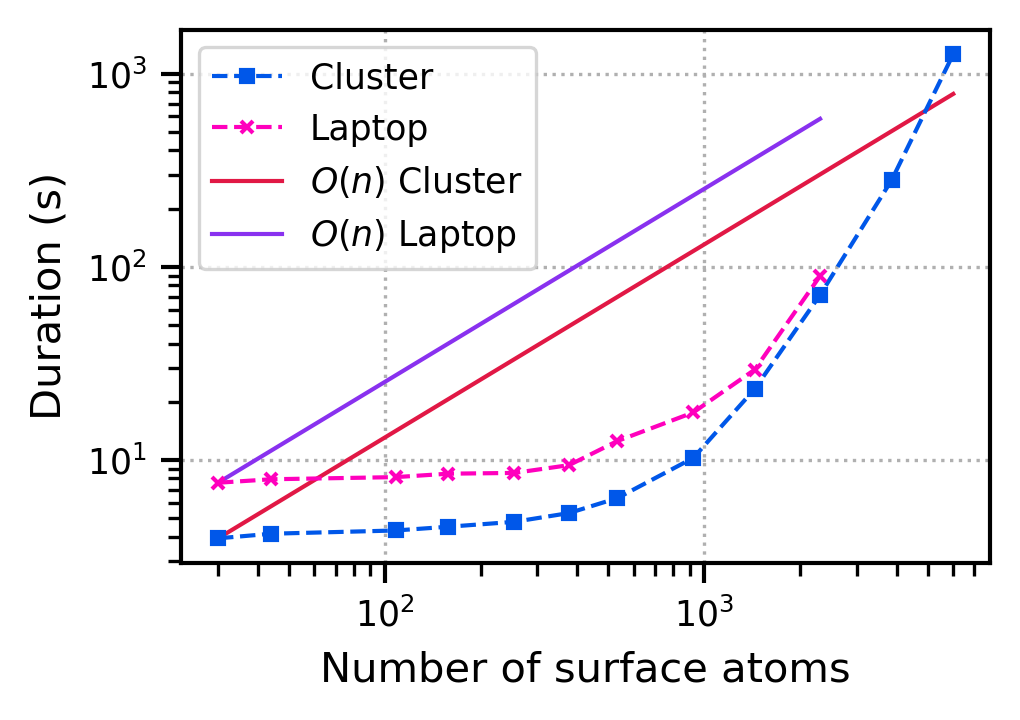

In [23]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(TC_VX_HPC_DF['nsatom'], TC_VX_HPC_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(TC_VX_LAP_DF['nsatom'], TC_VX_LAP_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='x', markersize=markerSize, color=hexCodes[2], zorder=3)
ax.plot(TC_VX_HPC_DF['nsatom'], TC_VX_HPC_DF['duration'][0] * (TC_VX_HPC_DF['nsatom'] / TC_VX_HPC_DF['nsatom'][0]), 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, 
        color=hexCodes[0], zorder=2)
ax.plot(TC_VX_LAP_DF['nsatom'], TC_VX_LAP_DF['duration'][0] * (TC_VX_LAP_DF['nsatom'] / TC_VX_LAP_DF['nsatom'][0]), 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, 
        color=hexCodes[3], zorder=2)
ax.loglog()
ax.set_xlabel('Number of surface atoms', fontsize='medium')
ax.set_ylabel('Duration (s)', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Cluster', 'Laptop', r'$O(n)$ Cluster', r'$O(n)$ Laptop'), fontsize='small')
plt.tight_layout()
plt.savefig('TC_VX_HPCvsLAP_loglog_satom.png')

#### Mathematically Exact Surface Representation

##### Load Data into Dataframes

In [24]:
TC_EX_HPC_NAtomsIdeal = (43, 86, 172, 344, 688, 1032, 2064, 4128, 8256, 16512, 33024, 66048)
TC_EX_HPC_Natoms = (43, 87, 177, 321, 683, 1055, 1961, 4189, 8007, 16187, 33573, 66283)
TC_EX_HPC_nsatoms = (30, 44, 108, 158, 254, 377, 534, 923, 1438, 2303, 3858, 6016)
TC_EX_HPC_Diameters = (10, 14, 17, 20, 27, 31, 38, 49, 61, 77, 98, 123)  # Angstroms

TC_EX_HPC_AllDurations = getAllDurations('runtimes/computationalComplexity', 'exhpc')
TC_EX_HPC_DurationsDF = pd.DataFrame(np.array(TC_EX_HPC_AllDurations).T, columns=TC_EX_HPC_Natoms) 
TC_EX_HPC_DurationsDF.head()

exhpc10
exhpc14
exhpc17
exhpc20
exhpc27
exhpc31
exhpc38
exhpc49
exhpc61
exhpc77
exhpc98
exhpc123


,43,87,177,321,683,1055,1961,4189,8007,16187,33573,66283
0,1.1390,1.2581,2.1657,3.3204,4.3859,6.1273,10.8673,21.0924,50.4123,140.8652,451.3710,1698.7821
1,1.0924,1.2040,1.9922,3.2040,4.1841,6.6135,10.1760,20.9209,49.9927,136.3066,433.7180,1734.8703
2,1.0837,1.2271,2.0503,3.2200,4.2306,6.2654,9.6755,22.3914,49.6997,139.4785,436.0032,1681.2716
3,1.1149,1.2056,2.0523,3.3085,4.5398,6.2721,10.1688,18.8953,44.3837,132.4826,449.2128,1674.5026
4,1.1557,1.2585,2.1875,3.3754,4.3044,6.2022,9.4043,20.9124,51.3365,136.7513,447.6191,1699.4092


In [25]:
TC_EX_LAP_NAtomsIdeal = TC_EX_HPC_NAtomsIdeal[:10]
TC_EX_LAP_Natoms = TC_EX_HPC_Natoms[:10]
TC_EX_LAP_nsatoms = TC_EX_HPC_nsatoms[:10]
TC_EX_LAP_Diameters = (10, 14, 17, 20, 27, 31, 38, 49, 61, 77, 98, 123)[:10]  # Angstroms

TC_EX_LAP_AllDurations = getAllDurations('runtimes/computationalComplexity', 'exlap')

TC_EX_LAP_DurationsDF = pd.DataFrame(np.array(TC_EX_LAP_AllDurations).T, columns=TC_EX_LAP_Natoms) 
TC_EX_LAP_DurationsDF.head()

exlap10
exlap14
exlap17
exlap20
exlap27
exlap31
exlap38
exlap49
exlap61
exlap77


,43,87,177,321,683,1055,1961,4189,8007,16187
0,1.2525,1.3516,3.3294,5.3771,7.1684,10.7114,12.1156,26.8824,69.6677,154.1708
1,1.1456,1.4427,2.6659,5.3265,7.3581,10.8296,12.3739,27.6277,69.8536,161.3627
2,1.1604,1.3443,2.8126,5.3790,7.5734,10.5645,12.4989,28.5169,62.2054,163.3142
3,1.1618,1.6157,2.7768,5.3583,7.5492,10.6475,12.5883,28.7163,64.6640,169.1051
4,1.2668,1.4435,3.1497,5.3772,7.1816,10.8114,12.5580,28.9246,67.2857,164.0672


##### Visualise via Box Plots

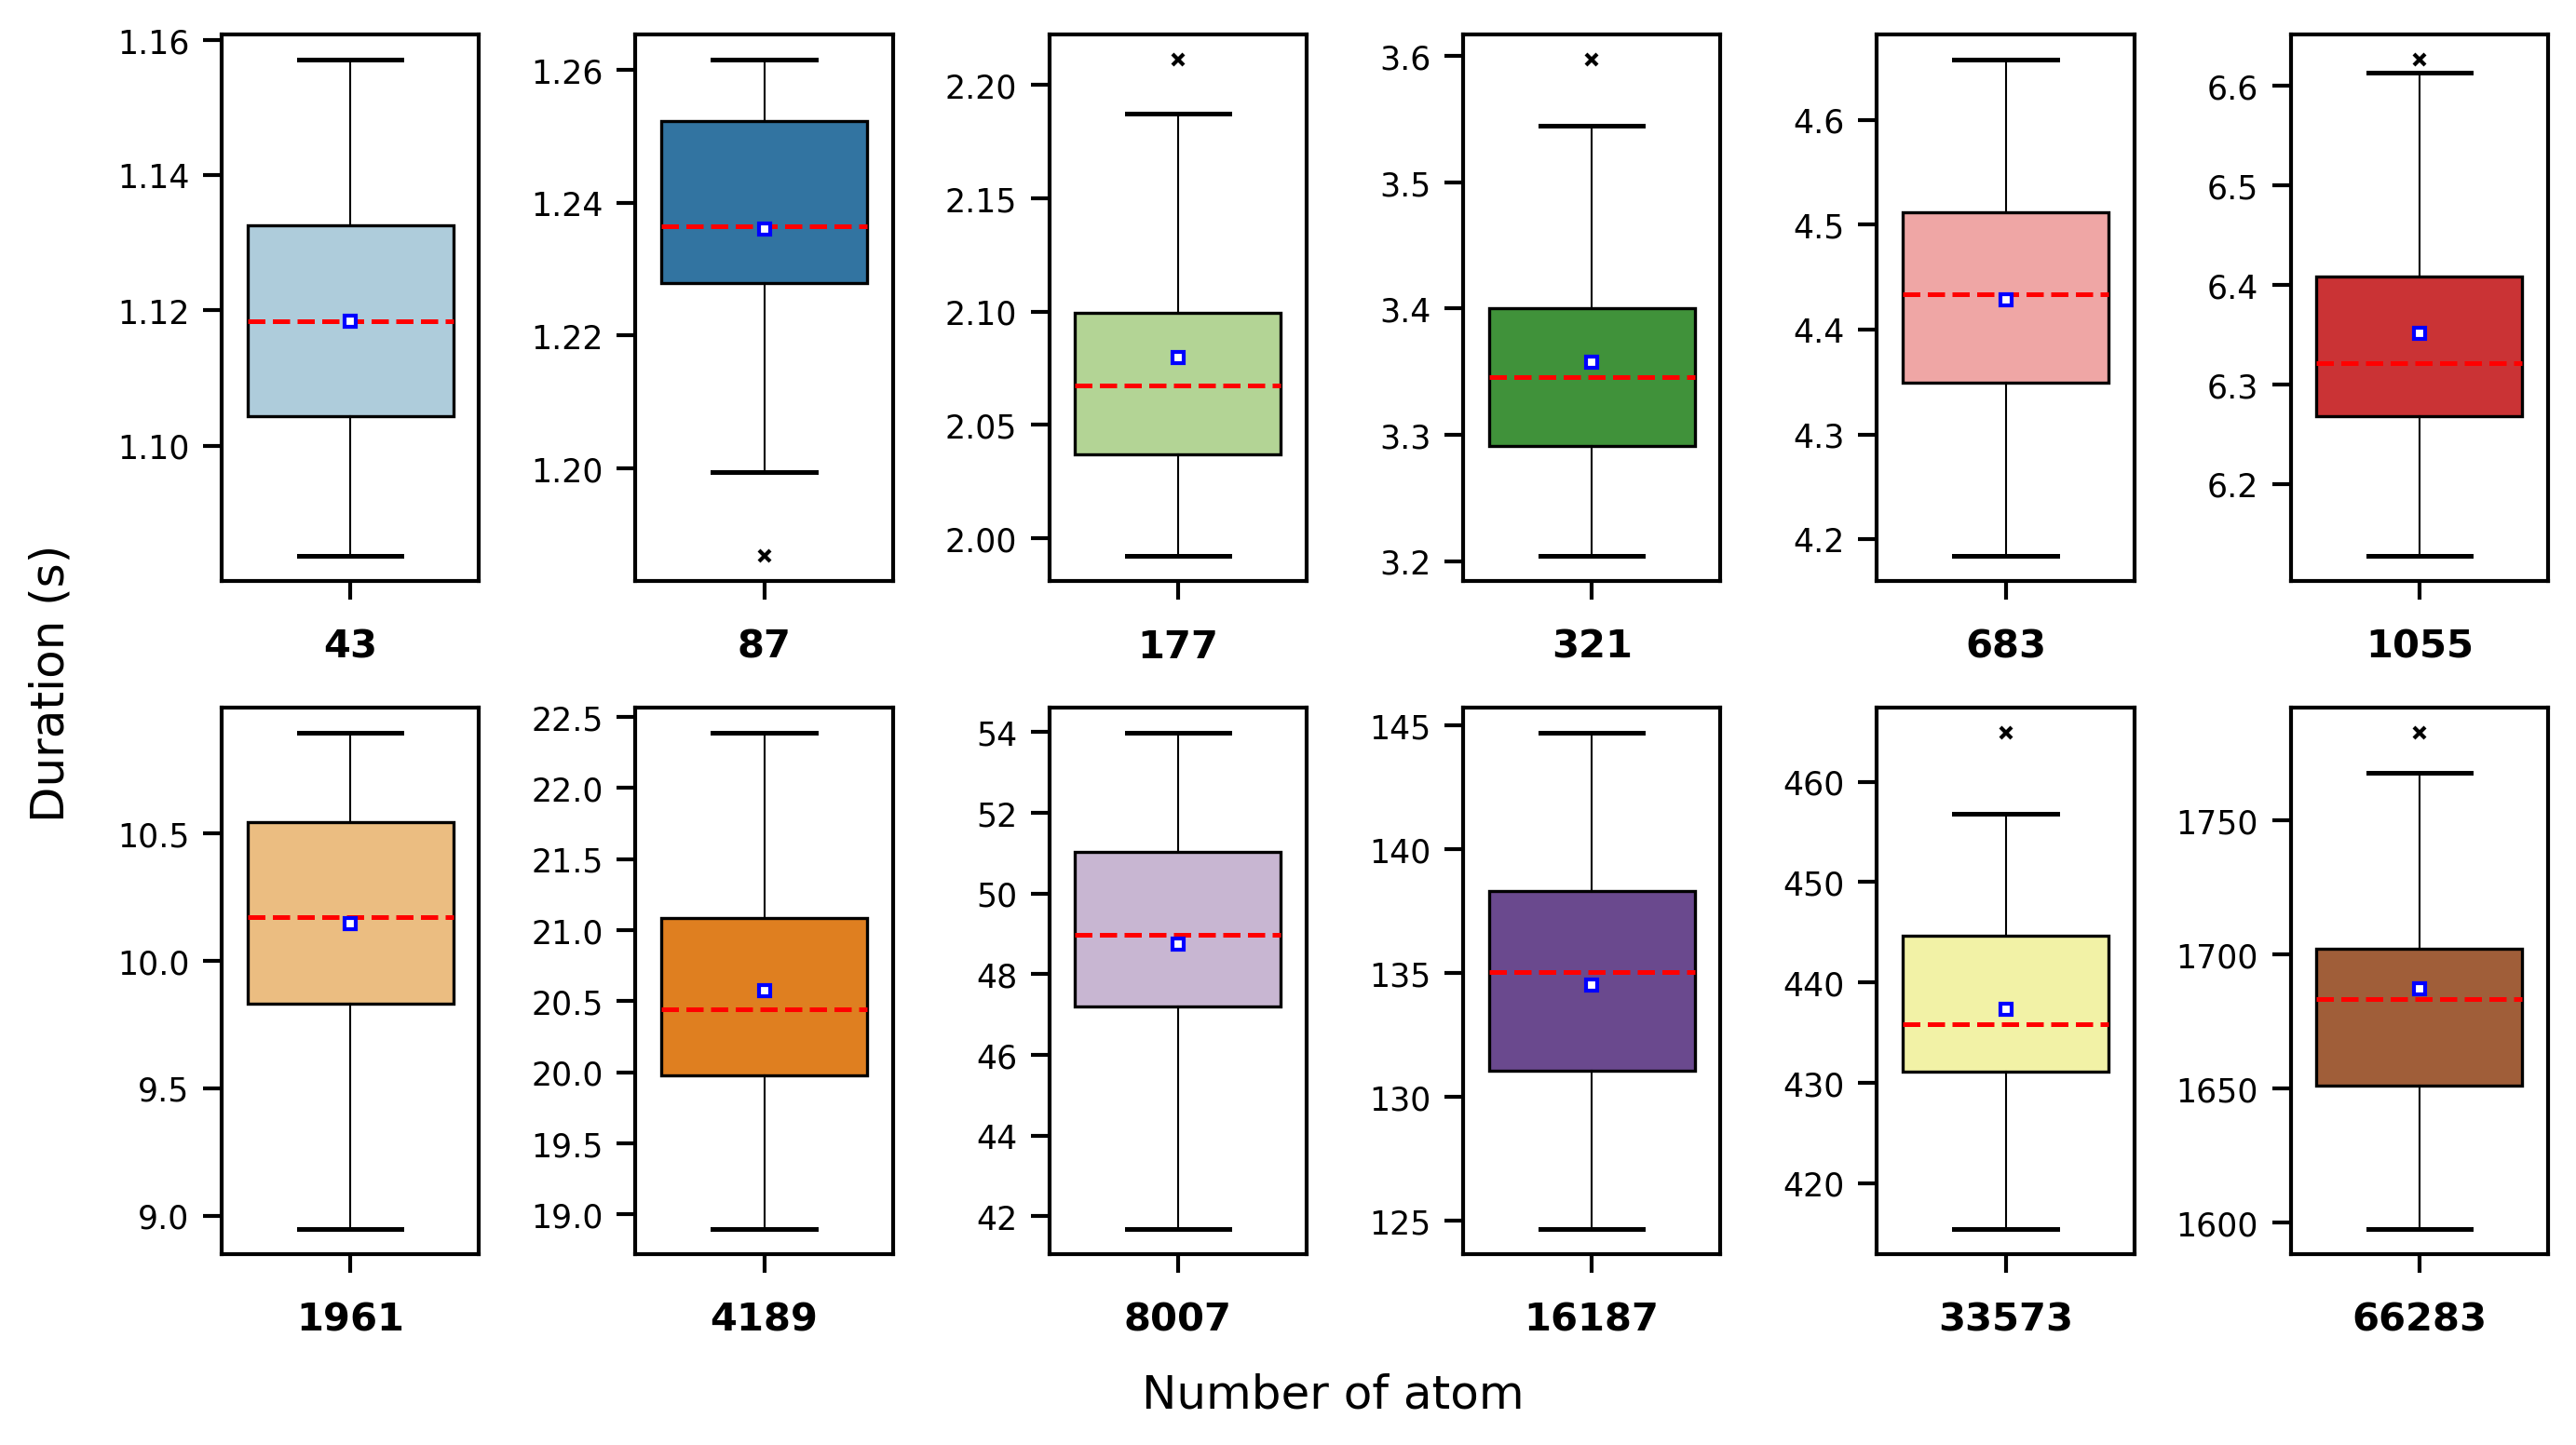

In [26]:
initBoxPlots(TC_EX_HPC_DurationsDF, 'Number of atom', 'EX', 'TC', 'HPC_')

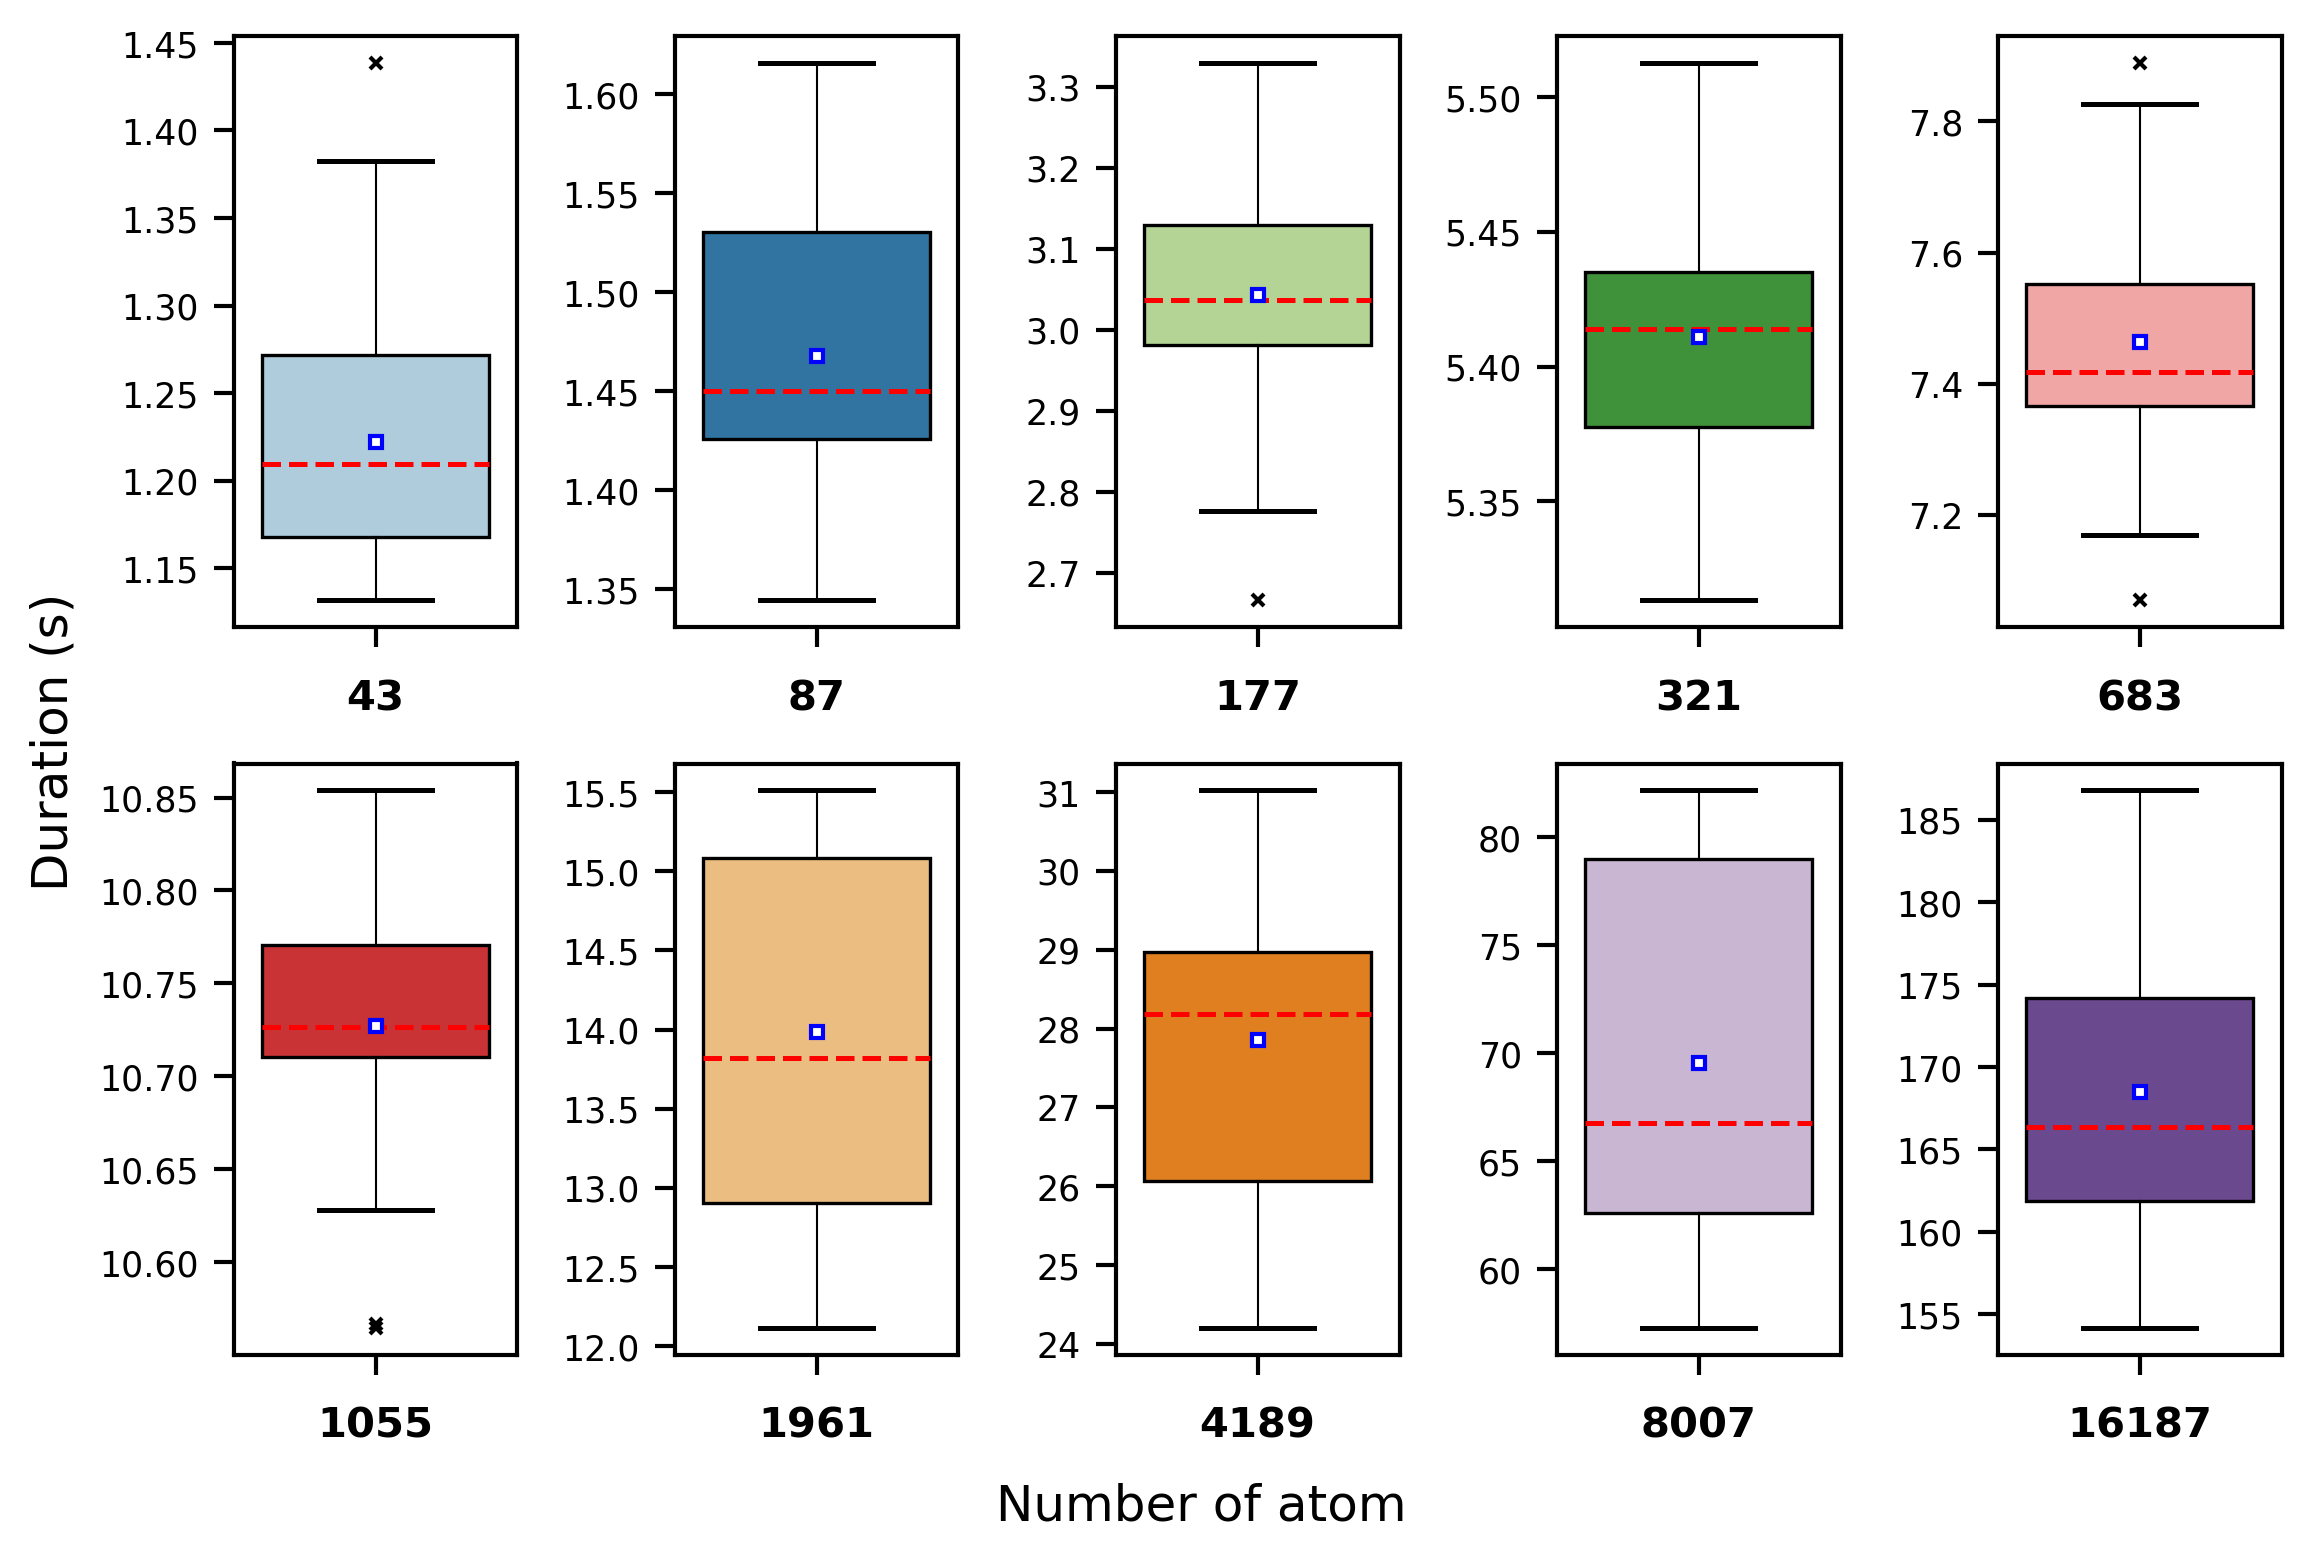

In [27]:
initBoxPlots(TC_EX_LAP_DurationsDF, 'Number of atom', 'EX', 'TC', 'LAP_')

##### Remove Outliers

In [28]:
TC_EX_HPC_Durations = []
for col in TC_EX_HPC_DurationsDF.columns:
    q1 = TC_EX_HPC_DurationsDF[col].quantile(0.25)
    q3 = TC_EX_HPC_DurationsDF[col].quantile(0.75)
    iqr = q3 - q1  # Interquartile range
    durationNoFlier = TC_EX_HPC_DurationsDF[col].loc[(TC_EX_HPC_DurationsDF[col] >= q1 - 1.5*iqr) & (TC_EX_HPC_DurationsDF[col] <= q3 + 1.5*iqr)]
    print(f"{col} atoms(s)\t: Retained {len(durationNoFlier)} out of 30 samples")
    TC_EX_HPC_Durations.append(durationNoFlier.mean())

43 atoms(s)	: Retained 30 out of 30 samples
87 atoms(s)	: Retained 29 out of 30 samples
177 atoms(s)	: Retained 29 out of 30 samples
321 atoms(s)	: Retained 29 out of 30 samples
683 atoms(s)	: Retained 30 out of 30 samples
1055 atoms(s)	: Retained 29 out of 30 samples
1961 atoms(s)	: Retained 30 out of 30 samples
4189 atoms(s)	: Retained 30 out of 30 samples
8007 atoms(s)	: Retained 30 out of 30 samples
16187 atoms(s)	: Retained 30 out of 30 samples
33573 atoms(s)	: Retained 29 out of 30 samples
66283 atoms(s)	: Retained 29 out of 30 samples


In [29]:
TC_EX_LAP_Durations = []
for col in TC_EX_LAP_DurationsDF.columns:
    q1 = TC_EX_LAP_DurationsDF[col].quantile(0.25)
    q3 = TC_EX_LAP_DurationsDF[col].quantile(0.75)
    iqr = q3 - q1  # Interquartile range
    durationNoFlier = TC_EX_LAP_DurationsDF[col].loc[(TC_EX_LAP_DurationsDF[col] >= q1 - 1.5*iqr) & (TC_EX_LAP_DurationsDF[col] <= q3 + 1.5*iqr)]
    print(f"{col} atoms(s)\t: Retained {len(durationNoFlier)} out of 30 samples")
    TC_EX_LAP_Durations.append(durationNoFlier.mean())

43 atoms(s)	: Retained 29 out of 30 samples
87 atoms(s)	: Retained 30 out of 30 samples
177 atoms(s)	: Retained 29 out of 30 samples
321 atoms(s)	: Retained 30 out of 30 samples
683 atoms(s)	: Retained 28 out of 30 samples
1055 atoms(s)	: Retained 28 out of 30 samples
1961 atoms(s)	: Retained 30 out of 30 samples
4189 atoms(s)	: Retained 30 out of 30 samples
8007 atoms(s)	: Retained 30 out of 30 samples
16187 atoms(s)	: Retained 30 out of 30 samples


##### Visualise Time Complexity Plots

In [30]:
TC_EX_HPC_DF = pd.DataFrame({'natom': TC_EX_HPC_Natoms, 'nsatom': TC_EX_HPC_nsatoms, 
                             'diameter': TC_EX_HPC_Diameters, 'duration': TC_EX_HPC_Durations})
TC_EX_HPC_DF.head()

,natom,nsatom,diameter,duration
0,43,30,10,1.118447
1,87,44,14,1.237707
2,177,108,17,2.075114
3,321,158,20,3.349559
4,683,254,27,4.428567


In [31]:
TC_EX_LAP_DF = pd.DataFrame({'natom': TC_EX_LAP_Natoms, 'nsatom': TC_EX_LAP_nsatoms, 
                             'diameter': TC_EX_LAP_Diameters, 'duration': TC_EX_LAP_Durations})
TC_EX_LAP_DF.head()

,natom,nsatom,diameter,duration
0,43,30,10,1.214566
1,87,44,14,1.467867
2,177,108,17,3.055621
3,321,158,20,5.410920
4,683,254,27,7.462471


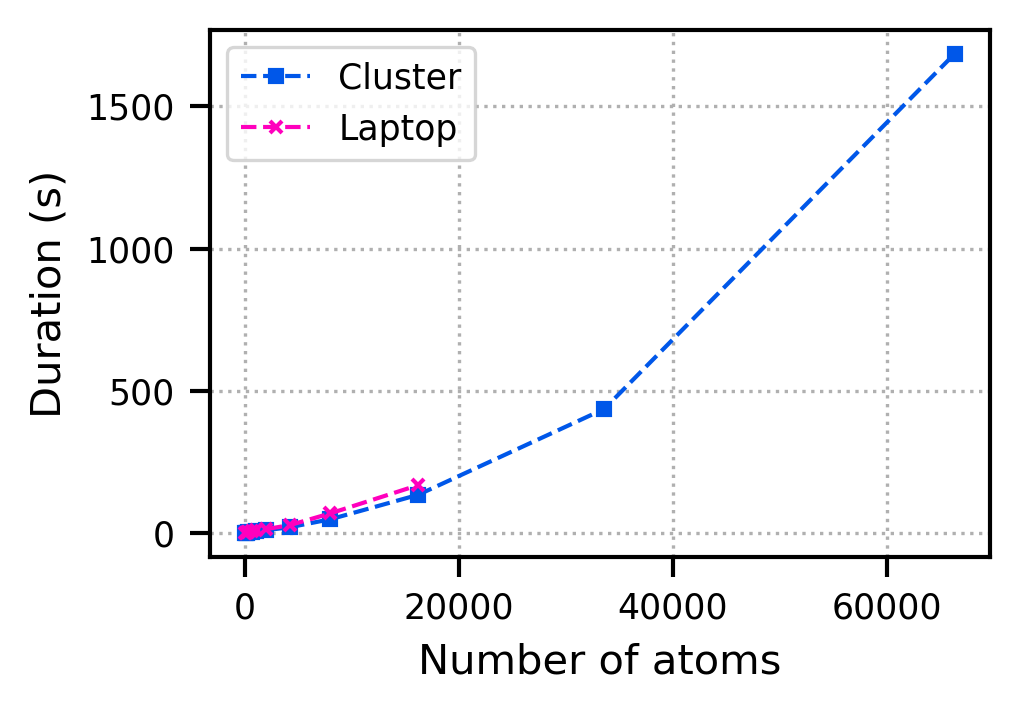

In [32]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(TC_EX_HPC_DF['natom'], TC_EX_HPC_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(TC_EX_LAP_DF['natom'], TC_EX_LAP_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='x', markersize=markerSize, color=hexCodes[2], zorder=3)
ax.set_xlabel('Number of atoms', fontsize='medium')
ax.set_ylabel('Duration (s)', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Cluster', 'Laptop'), fontsize='small')
plt.tight_layout()
plt.savefig('TC_EX_HPCvsLAP.png')

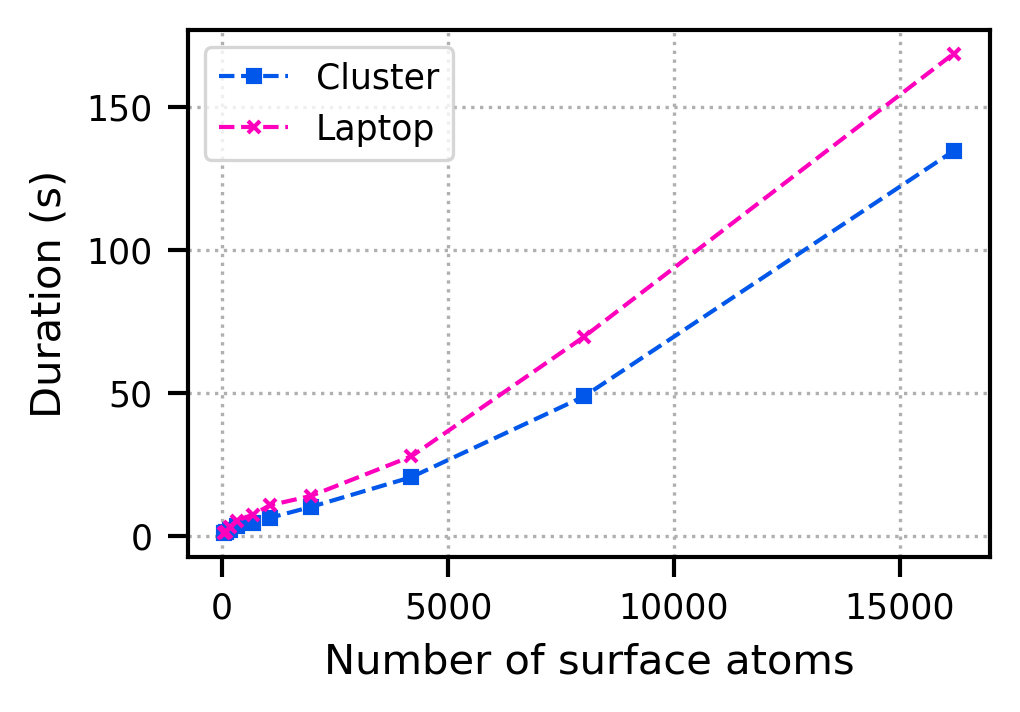

In [33]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(TC_EX_HPC_DF['natom'][:10], TC_EX_HPC_DF['duration'][:10], 
        linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(TC_EX_LAP_DF['natom'], TC_EX_LAP_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='x', markersize=markerSize, color=hexCodes[2], zorder=3)
ax.set_xlabel('Number of surface atoms', fontsize='medium')
ax.set_ylabel('Duration (s)', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Cluster', 'Laptop'), fontsize='small')
plt.tight_layout()
plt.savefig('TC_EX_HPCvsLAP_SysErr.png')

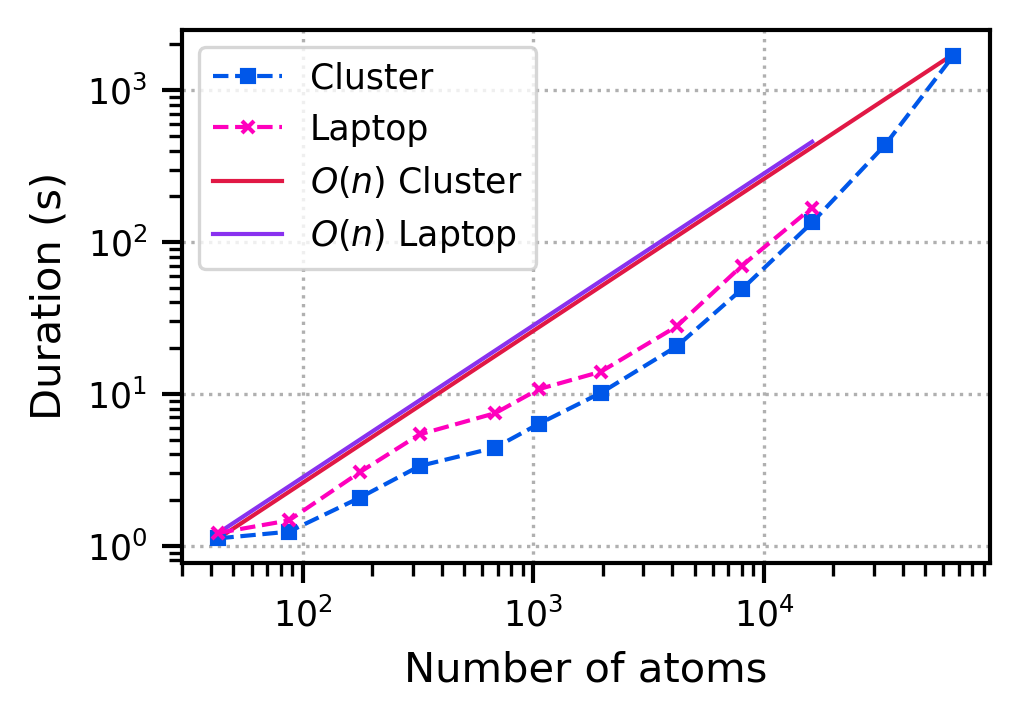

In [34]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(TC_EX_HPC_DF['natom'], TC_EX_HPC_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(TC_EX_LAP_DF['natom'], TC_EX_LAP_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='x', markersize=markerSize, color=hexCodes[2], zorder=3)
ax.plot(TC_EX_HPC_DF['natom'], TC_EX_HPC_DF['duration'][0] * (TC_EX_HPC_DF['natom'] / TC_EX_HPC_DF['natom'][0]), 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, 
        color=hexCodes[0], zorder=2)
ax.plot(TC_EX_LAP_DF['natom'], TC_EX_LAP_DF['duration'][0] * (TC_EX_LAP_DF['natom'] / TC_EX_LAP_DF['natom'][0]), 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, 
        color=hexCodes[3], zorder=2)
ax.loglog()
ax.set_xlabel('Number of atoms', fontsize='medium')
ax.set_ylabel('Duration (s)', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Cluster', 'Laptop', r'$O(n)$ Cluster', r'$O(n)$ Laptop'), fontsize='small')
plt.tight_layout()
plt.savefig('TC_EX_HPCvsLAP_loglog.png')

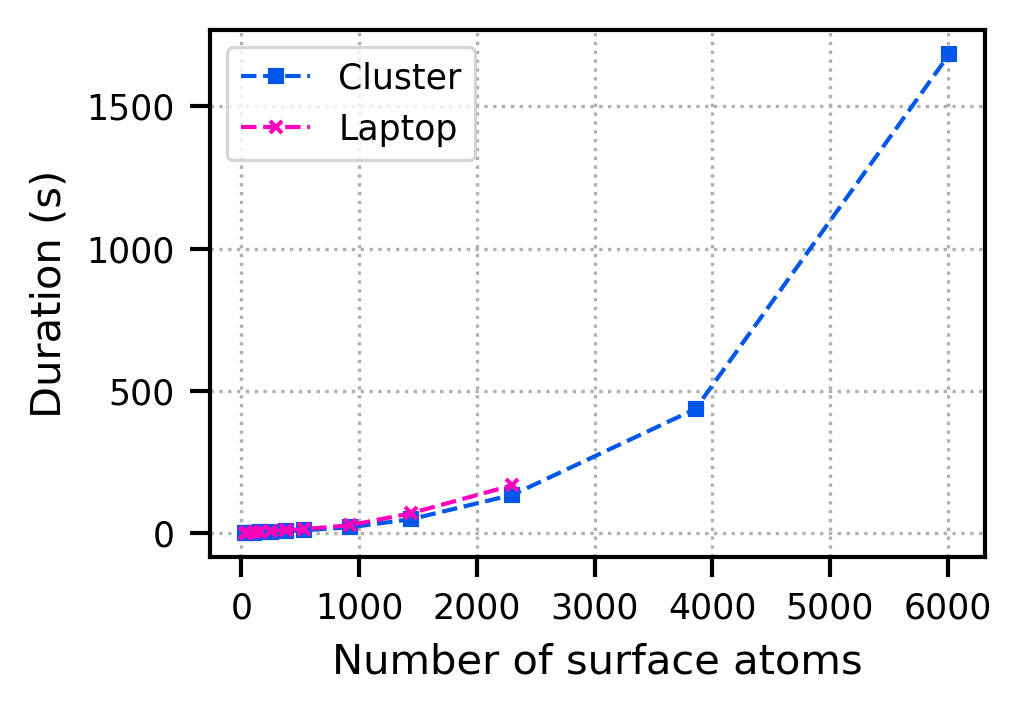

In [35]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(TC_EX_HPC_DF['nsatom'], TC_EX_HPC_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(TC_EX_LAP_DF['nsatom'], TC_EX_LAP_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='x', markersize=markerSize, color=hexCodes[2], zorder=3)
ax.set_xlabel('Number of surface atoms', fontsize='medium')
ax.set_ylabel('Duration (s)', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Cluster', 'Laptop'), fontsize='small')
plt.tight_layout()
plt.savefig('TC_EX_HPCvsLAP_satom.png')

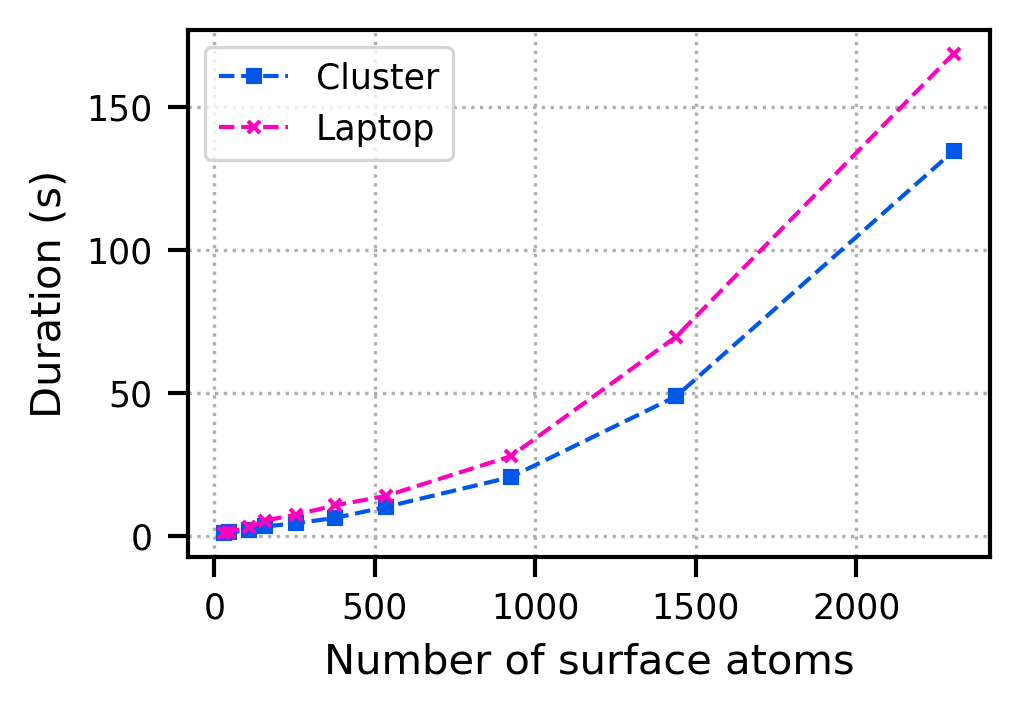

In [36]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(TC_EX_HPC_DF['nsatom'][:10], TC_EX_HPC_DF['duration'][:10], 
        linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(TC_EX_LAP_DF['nsatom'], TC_EX_LAP_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='x', markersize=markerSize, color=hexCodes[2], zorder=3)
ax.set_xlabel('Number of surface atoms', fontsize='medium')
ax.set_ylabel('Duration (s)', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Cluster', 'Laptop'), fontsize='small')
plt.tight_layout()
plt.savefig('TC_EX_HPCvsLAP_SysErr_satom.png')

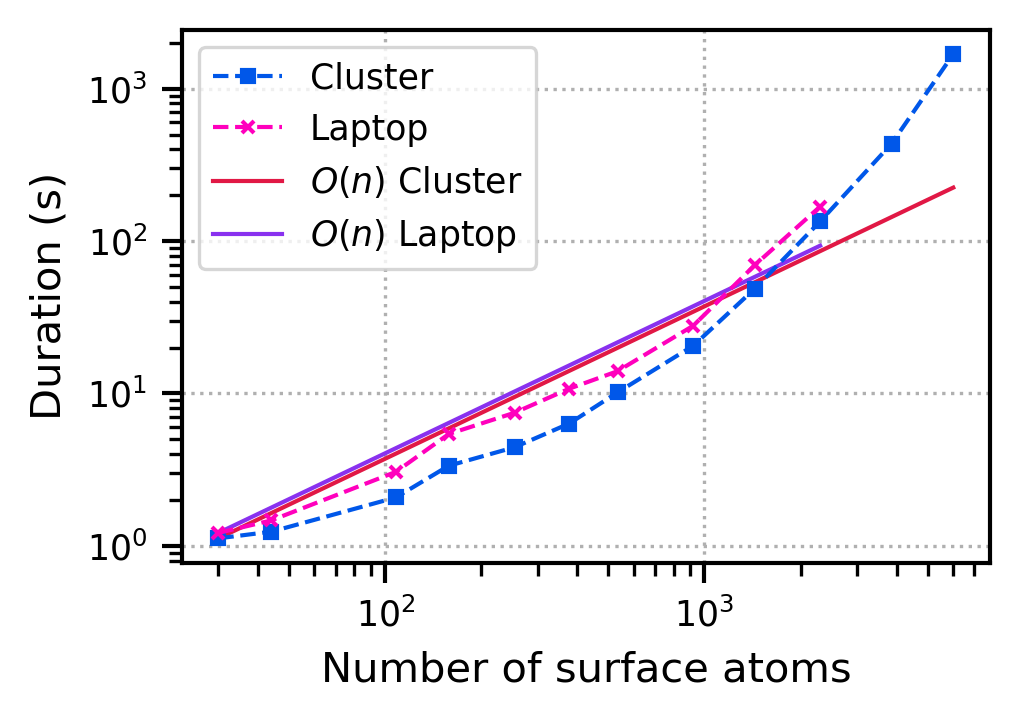

In [37]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(TC_EX_HPC_DF['nsatom'], TC_EX_HPC_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(TC_EX_LAP_DF['nsatom'], TC_EX_LAP_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='x', markersize=markerSize, color=hexCodes[2], zorder=3)
ax.plot(TC_EX_HPC_DF['nsatom'], TC_EX_HPC_DF['duration'][0] * (TC_EX_HPC_DF['nsatom'] / TC_EX_HPC_DF['nsatom'][0]), 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, 
        color=hexCodes[0], zorder=2)
ax.plot(TC_EX_LAP_DF['nsatom'], TC_EX_LAP_DF['duration'][0] * (TC_EX_LAP_DF['nsatom'] / TC_EX_LAP_DF['nsatom'][0]), 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, 
        color=hexCodes[3], zorder=2)
ax.loglog()
ax.set_xlabel('Number of surface atoms', fontsize='medium')
ax.set_ylabel('Duration (s)', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Cluster', 'Laptop', r'$O(n)$ Cluster', r'$O(n)$ Laptop'), fontsize='small')
plt.tight_layout()
plt.savefig('TC_EX_HPCvsLAP_loglog_satom.png')

## Scalability Tests

Scalability, also referred to as parallelisation efficiency, is the ability to handle more work as the amount of resources grows. It is important for parallel computing to be efficient. Ideally, algorithms should have a linear speedup as the number of processors increases, but that is extremely difficult to be attained in real world applications, as it would imply 100% contribution of computational power from each processor.

When using high performance computing clusters, it is often worthwhile to measure the scaling of the algorithms used for resource planning. This is done via:

* strong scaling, which concerns the speedup for a fixed problem size with respect to the number of processors, and is governed by [Amdahl's law](https://en.wikipedia.org/wiki/Amdahl%27s_law); and
* weak scaling, which concerns the speedup for a scaled problem size with respect to the number of processors, and is governed by [Gustafson's law](https://en.wikipedia.org/wiki/Gustafson%27s_law). 

The results of strong and weak scaling tests can provide good indications for the best match between job size and the amount of resources that should be requested for a particular job. Note that scalability testing measures the ability of the algorithm to perform with varying problem sizes and number of processors. It DOES NOT test the general functionality or correctness of the algorithm.

### Technical Specifications

The scalability tests were run on [Gadi](https://nci.org.au/our-systems/hpc-systems).

### Settings

The run times were obtained from 30 independent runs of the whole pipeline, using configurations/parameters expected for production runs, i.e. no simplified model is used in accordance to the advice from [HPC Wiki](https://hpc-wiki.info/hpc/Scaling).

### Strong Scaling

To calculate strong scaling speedup, the number of processors is increased while the problem size remains constant, which results in a reduced workload per processor.

The test case here is a spherical palladium nanoparticle with a diameter of 100 Angstrom, which has an atom count of 3952.

In [38]:
SS_Ncpus = (1, 2, 4, 8, 16, 24, 48, 96, 192, 384, 768, 1536)
SS_Nnodes = (1, 1, 1, 1, 1, 1, 1, 2, 4, 8, 16, 32)

#### Voxelised Point Cloud Surface Representation

##### Outliers Removal

In [39]:
SS_VX_AllDurationFiles = [fname for fname in listdir('runtimes/strongScaling') if 'vx' in fname]
SS_VX_AllDurations = []
for fname in natsorted(SS_VX_AllDurationFiles):
    with open(f"runtimes/strongScaling/{fname}", 'r') as f:
        durations = []
        for line in f:
            if 'Run ' in line:
                durations.append(float(line.strip().split()[-2]))
    SS_VX_AllDurations.append(durations)

SS_VX_DurationsDF = pd.DataFrame(np.array(SS_VX_AllDurations).T, columns=SS_Ncpus) 
SS_VX_DurationsDF.head()

,1,2,4,8,16,24,48,96,192,384,768,1536
0,386.1582,336.8456,322.8707,315.4282,303.5788,308.6491,310.7862,307.4700,309.0989,306.8515,321.8707,340.8141
1,390.6118,336.9990,320.4670,320.0716,307.2299,312.1230,309.7769,310.7209,313.6722,308.7289,321.4144,340.4234
2,388.2873,344.0305,325.4448,310.7256,309.6133,311.0804,311.7956,312.0298,312.0279,316.7406,325.2056,354.1482
3,387.8483,341.0909,325.3177,312.4562,327.4313,309.2130,306.2863,304.2935,312.5814,310.9938,319.2594,333.9092
4,384.7875,341.0597,321.1962,316.6931,303.9335,308.3564,310.0356,311.3150,324.9730,328.5702,316.1970,352.5230


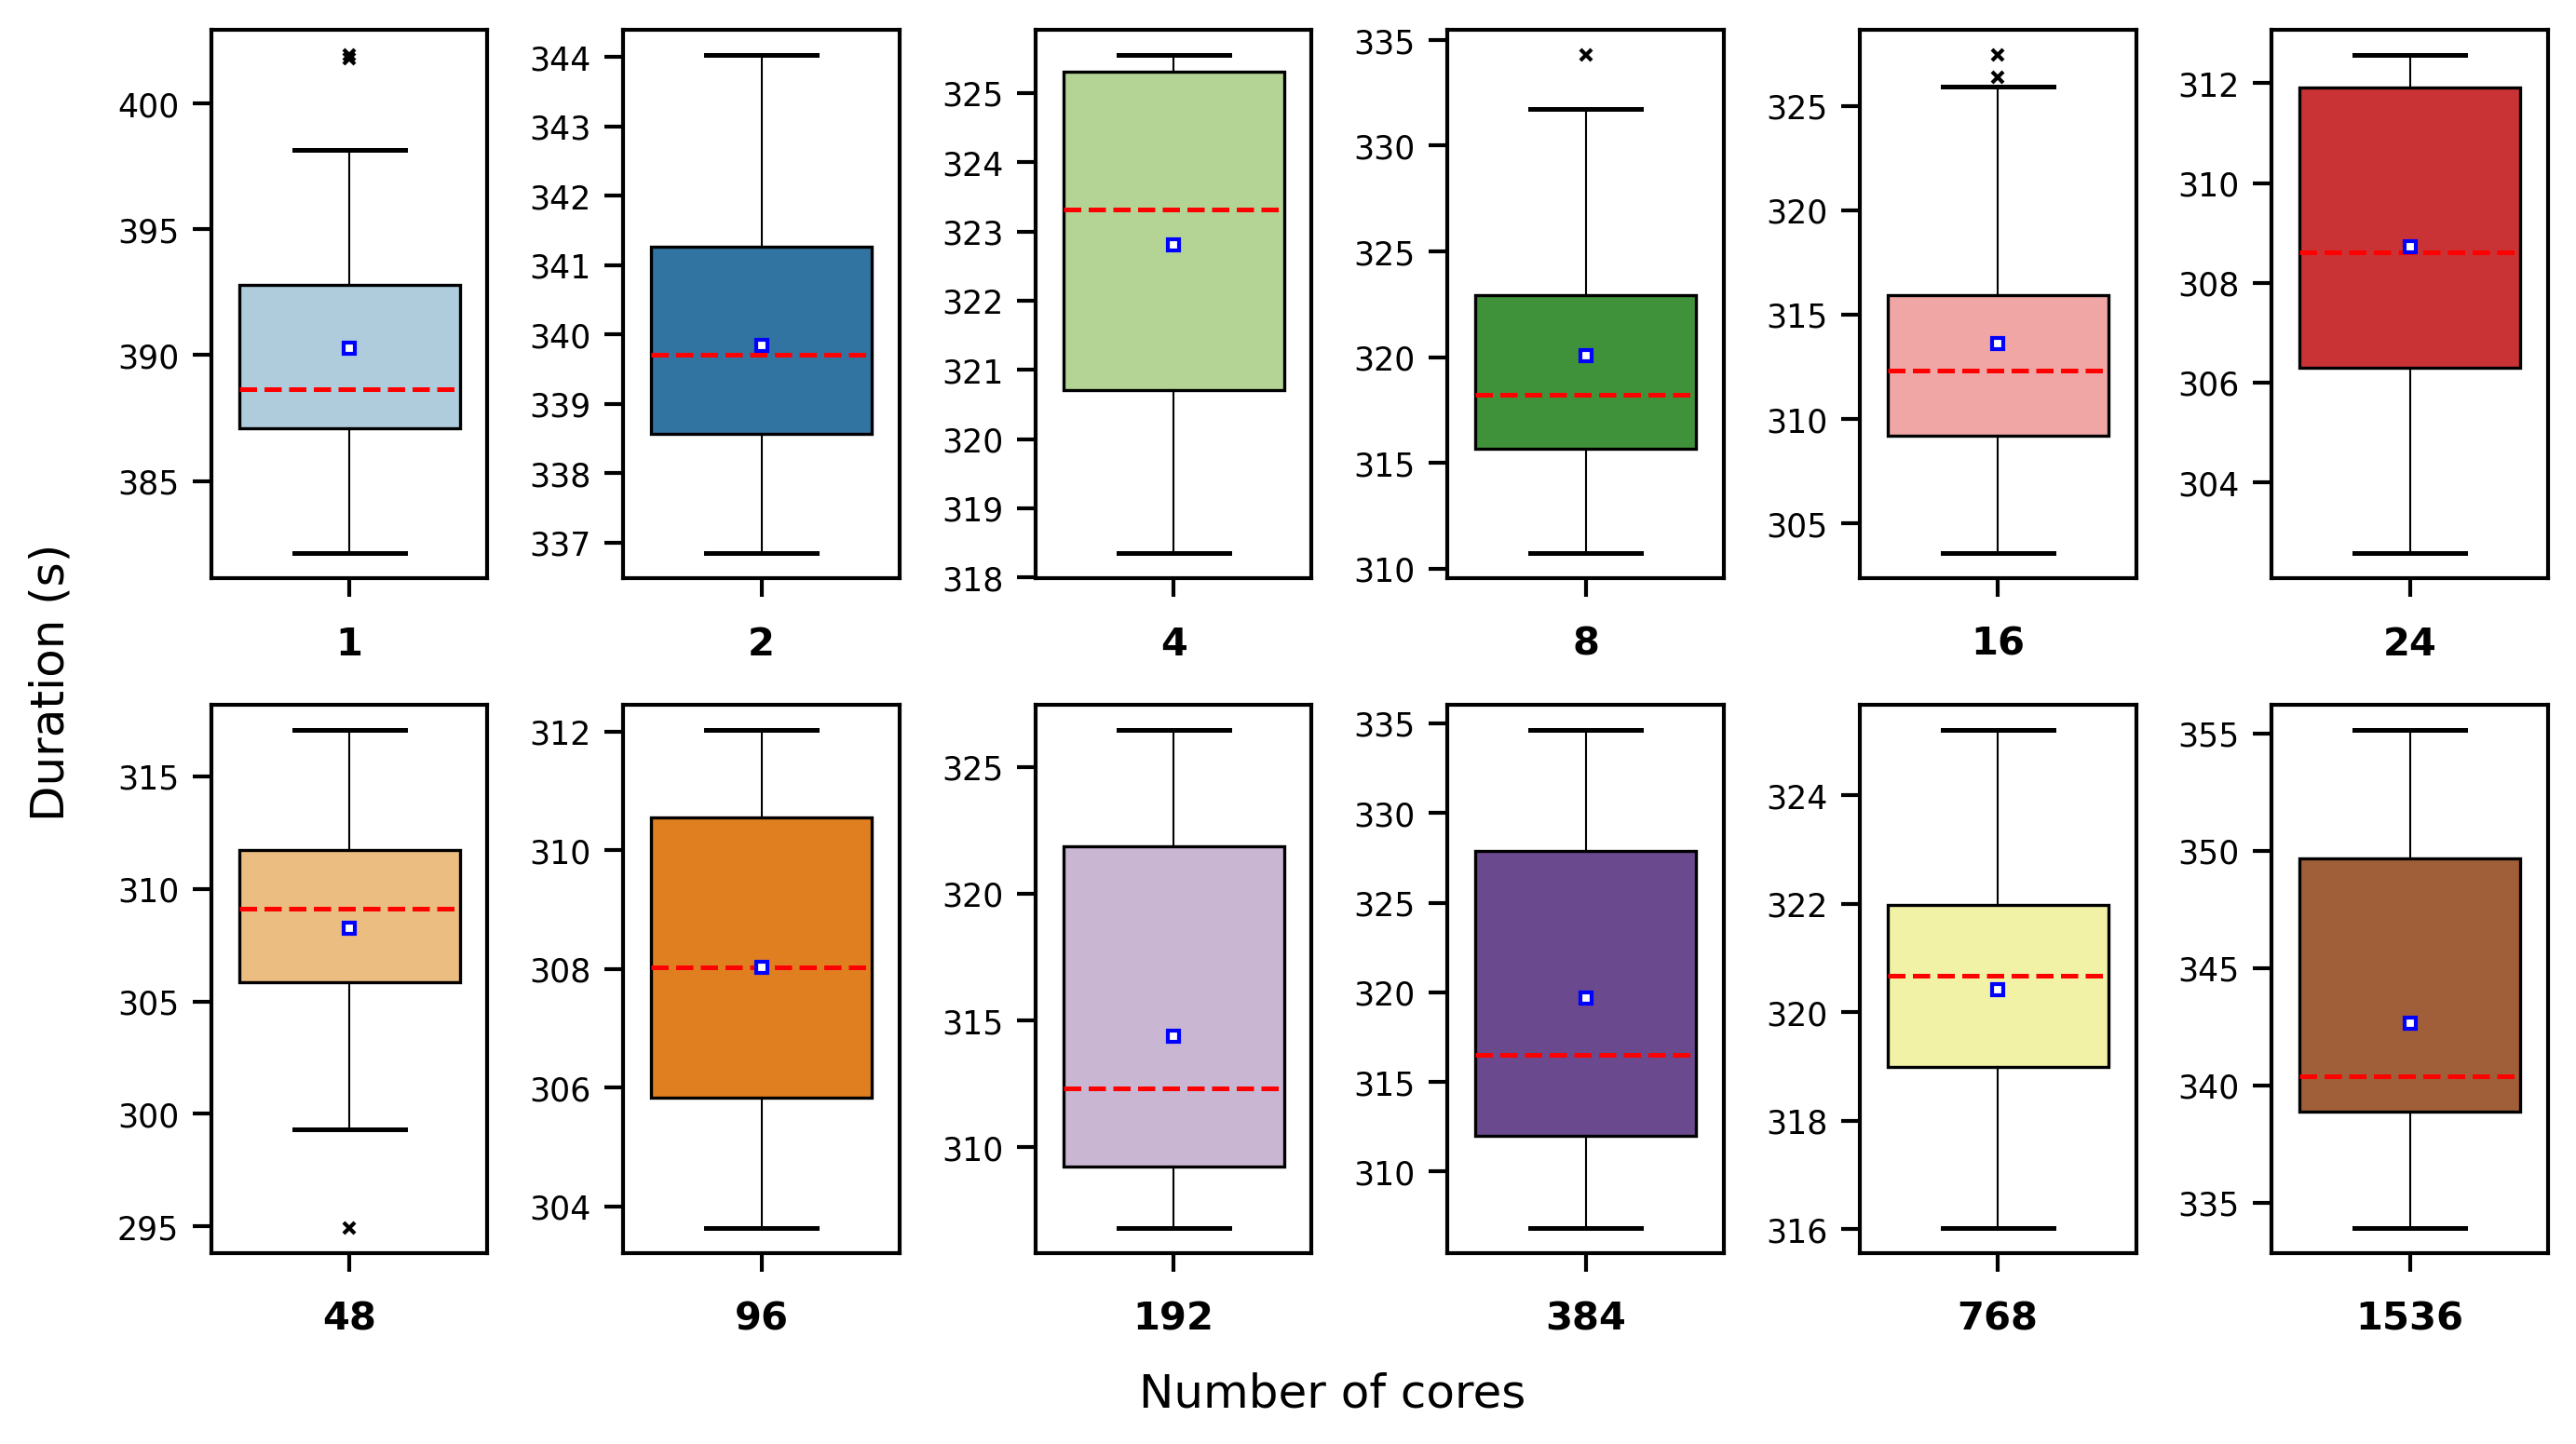

In [40]:
initBoxPlots(SS_VX_DurationsDF, 'Number of cores', 'VX', 'SS', '')

In [41]:
SS_VX_Durations = rmOutliers(SS_VX_DurationsDF, 'cpu')

1 cpu(s)	: Retained 30 out of 30 samples
2 cpu(s)	: Retained 30 out of 30 samples
4 cpu(s)	: Retained 30 out of 30 samples
8 cpu(s)	: Retained 30 out of 30 samples
16 cpu(s)	: Retained 30 out of 30 samples
24 cpu(s)	: Retained 30 out of 30 samples
48 cpu(s)	: Retained 30 out of 30 samples
96 cpu(s)	: Retained 30 out of 30 samples
192 cpu(s)	: Retained 30 out of 30 samples
384 cpu(s)	: Retained 30 out of 30 samples
768 cpu(s)	: Retained 30 out of 30 samples
1536 cpu(s)	: Retained 30 out of 30 samples


##### Speedup Computation

We can then compute the strong scaling speedups and efficiencies:

In [42]:
SS_VX_DF = pd.DataFrame({'ncpu': SS_Ncpus, 'nnode': SS_Nnodes, 'duration': SS_VX_Durations})
SS_VX_DF['speedup'] = SS_VX_DF['duration'][0] / SS_VX_DF['duration']
SS_VX_DF['efficiency'] = (SS_VX_DF['duration'][0]*SS_VX_DF['ncpu'][0]) / (SS_VX_DF['duration']*SS_VX_DF['ncpu'])
SS_VX_DF.head()

,ncpu,nnode,duration,speedup,efficiency
0,1,1,389.459021,1.000000,1.000000
1,2,1,339.846540,1.145985,0.572992
2,4,1,322.801170,1.206498,0.301625
3,8,1,319.555907,1.218751,0.152344
4,16,1,312.648746,1.245676,0.077855


##### Visualisation

And plot them:

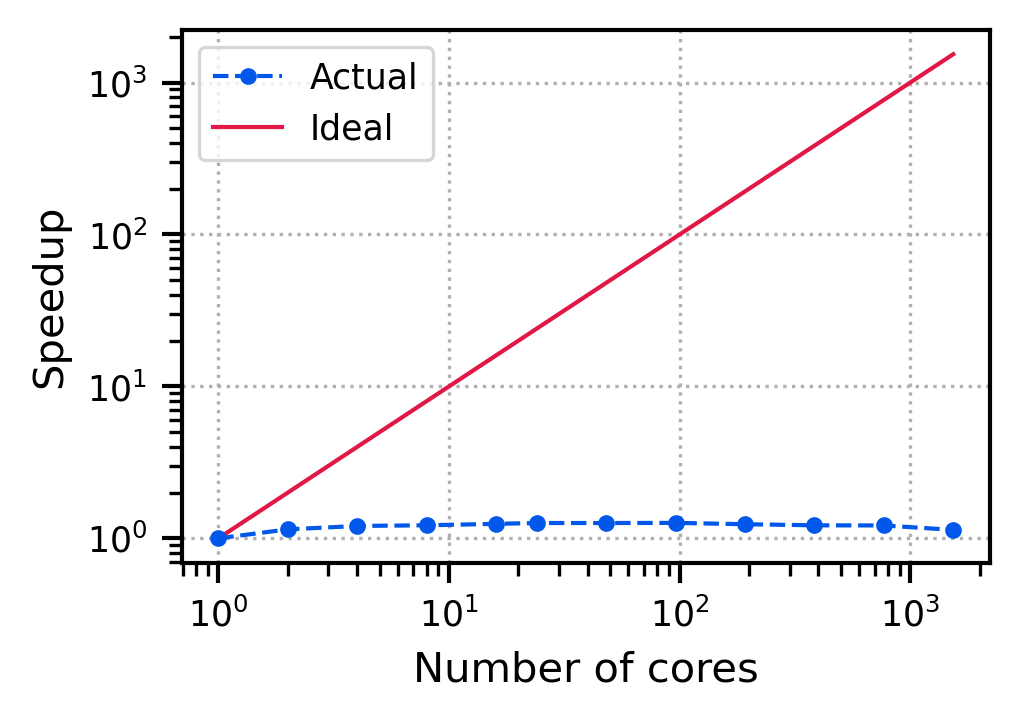

In [43]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
# SS_EX_DF.plot(x='ncpu', y='speedup', kind='line', ax=ax, figsize=figSize, title='Strong Scaling Voxelised Surface Speedup', grid=False, legend=True, style='o-', 
#               loglog=True, xlabel='Number of CPUs', ylabel='Speedup', fontsize=labelSize, colormap='Set1')
ax.plot(SS_VX_DF['ncpu'], SS_VX_DF['speedup'], 
        linewidth=lineWidth, linestyle='--', marker='o', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(SS_VX_DF['ncpu'], SS_VX_DF['ncpu'], 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, color=hexCodes[0], zorder=2)  # Amdahl's Law
ax.loglog()
ax.set_xlabel('Number of cores', fontsize='medium')
ax.set_ylabel('Speedup', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
# ax.set_title('Strong Scaling Voxelised Surface Speedups')
ax.legend(labels=('Actual', 'Ideal'), fontsize='small')
plt.tight_layout()
plt.savefig('SS_VX_Speedups.png')

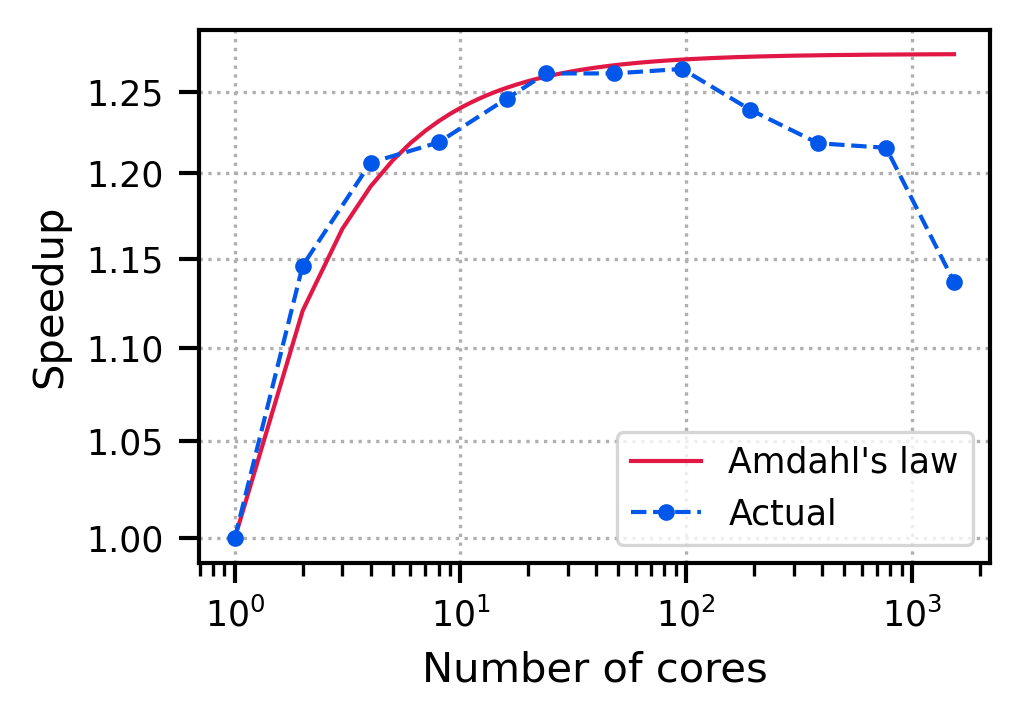

In [44]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)

# Amdahl's law
p = 0.215
s = np.array(range(1, SS_Ncpus[-1]+1))
amdahl = 1 / ((1-p) + p/s)
ax.plot(s, amdahl, 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, color=hexCodes[0], zorder=2)

ax.plot(SS_VX_DF['ncpu'], SS_VX_DF['speedup'], 
        linewidth=lineWidth, linestyle='--', marker='o', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.loglog()
ax.set_xlabel('Number of cores', fontsize='medium')
ax.set_ylabel('Speedup', fontsize='medium')
ax.set_yticks([1.00, 1.05, 1.10, 1.15, 1.20, 1.25])
ax.tick_params(axis='both', labelsize='small')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.grid(linestyle='dotted')
ax.legend(labels=("Amdahl's law", 'Actual'), fontsize='small')
# ax.set_title('Strong Scaling Voxelised Surface Actual Speedup')
plt.tight_layout()
plt.savefig('SS_VX_Speedup.png')

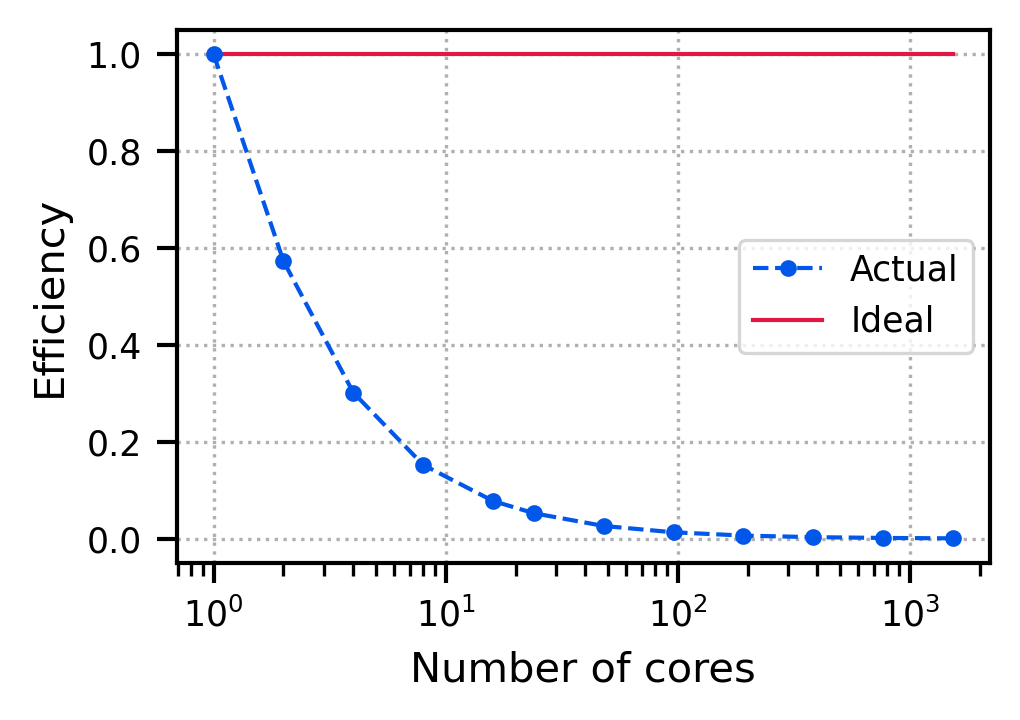

In [45]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
# strongScalingDF.plot(x='ncpu', y='speedup', kind='line', ax=ax, figsize=figSize, title='Strong Scaling Voxelised Surface Speedup', grid=False, legend=True, style='o-', 
                     # loglog=True, xlabel='Number of CPUs', ylabel='Speedup', fontsize=labelSize, colormap='Set1')
ax.plot(SS_VX_DF['ncpu'], SS_VX_DF['efficiency'], 
        linewidth=lineWidth, linestyle='--', marker='o', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(SS_VX_DF['ncpu'], [1] * len(SS_VX_DF['ncpu']), 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, color=hexCodes[0], zorder=2)
plt.xscale('log')
ax.set_xlabel('Number of cores', fontsize='medium')
ax.set_ylabel('Efficiency', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Actual', 'Ideal'), fontsize='small')
# ax.set_title('Strong Scaling Voxelised Surface Efficiency')
plt.tight_layout()
plt.savefig('SS_VX_Efficiency.png')

#### Mathematically Exact Surface Representation

##### Outliers Removal

In [46]:
SS_EX_AllDurationFiles = [fname for fname in listdir('runtimes/strongScaling') if 'ex' in fname]
SS_EX_AllDurations = []
for fname in natsorted(SS_EX_AllDurationFiles):
    with open(f"runtimes/strongScaling/{fname}", 'r') as f:
        durations = []
        for line in f:
            if 'Run ' in line:
                durations.append(float(line.strip().split()[-2]))
    SS_EX_AllDurations.append(durations)

SS_EX_DurationsDF = pd.DataFrame(np.array(SS_EX_AllDurations).T, columns=SS_Ncpus) 
SS_EX_DurationsDF.head()

,1,2,4,8,16,24,48,96,192,384,768,1536
0,1238.6910,835.4171,810.3578,492.3368,392.9823,373.6399,349.0600,347.2038,363.6947,336.3814,343.5624,329.0045
1,1237.8491,832.5869,787.9684,497.7898,397.5634,379.6723,344.9647,345.2666,354.0070,335.8143,341.4819,329.6668
2,1236.4769,835.0222,803.3268,543.6478,388.2216,381.6311,345.4551,350.6169,364.2074,335.6076,332.7942,330.0887
3,1235.4844,836.2932,664.4918,504.5241,389.2547,382.0802,349.0722,344.3185,355.7219,338.6278,341.6045,332.2796
4,1234.9347,836.1331,687.9276,487.9890,388.8013,375.8590,345.5229,348.8305,359.8261,335.1206,344.8709,325.6960


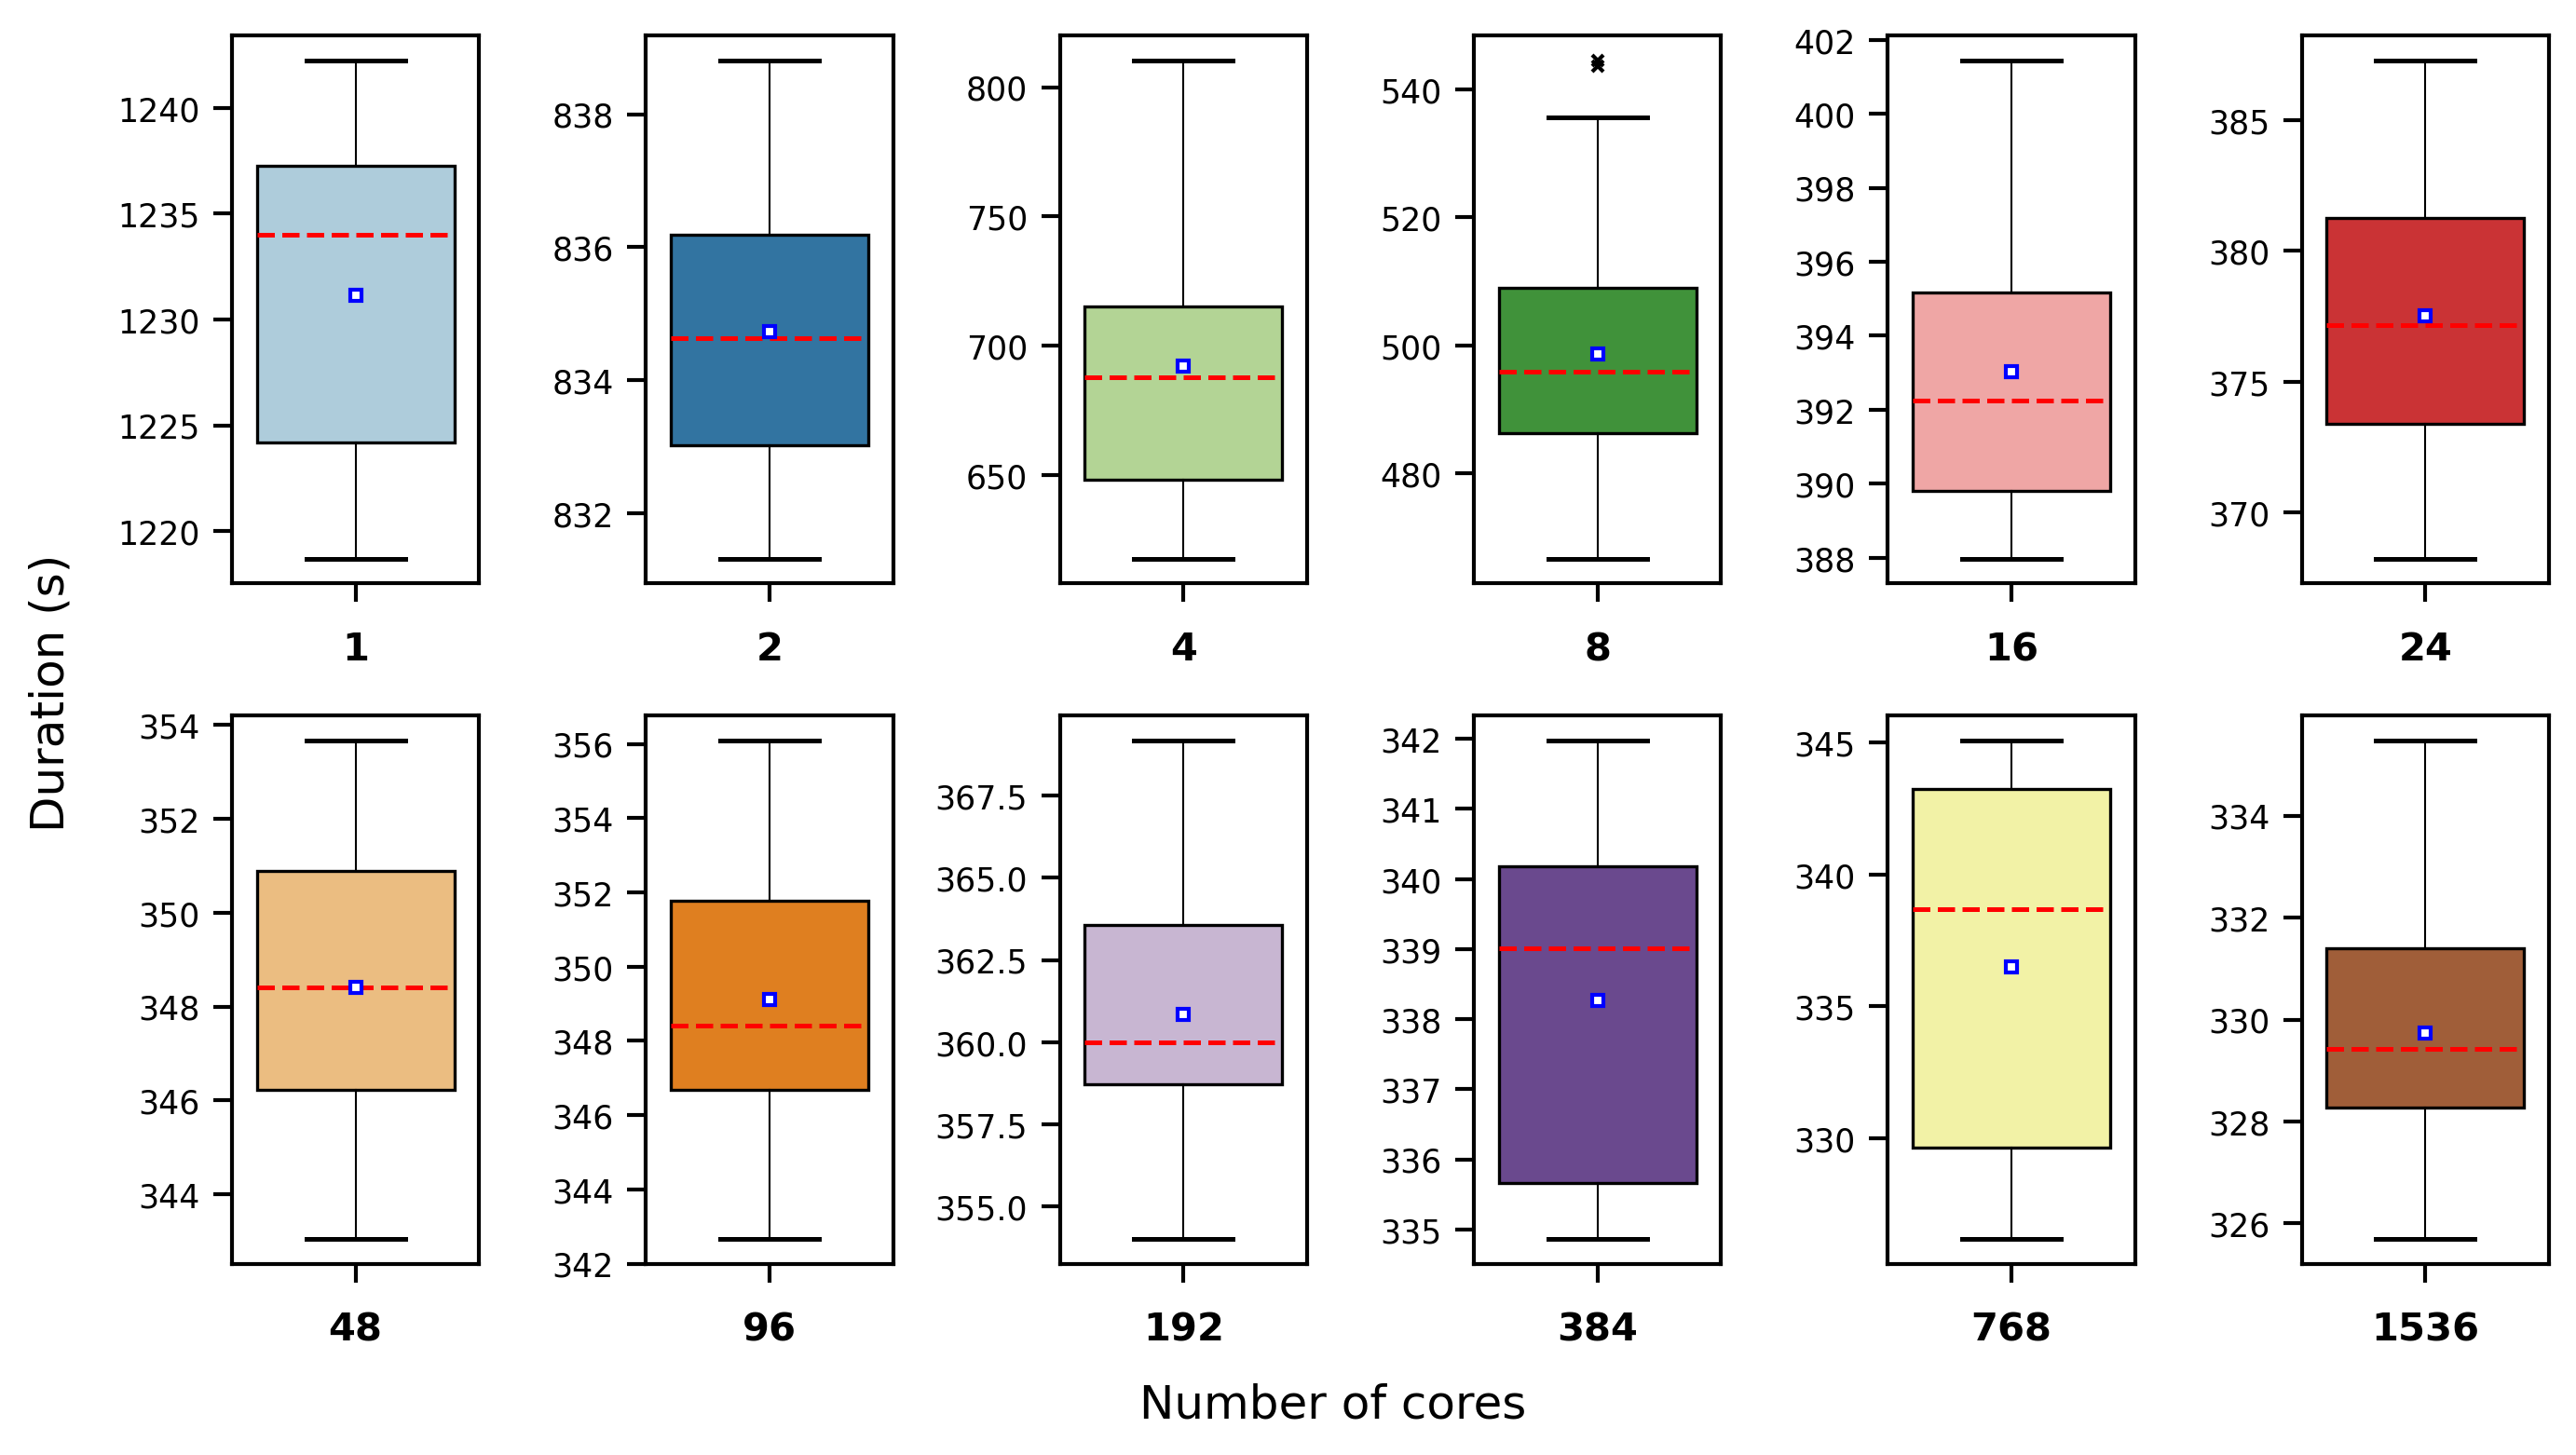

In [47]:
initBoxPlots(SS_EX_DurationsDF, 'Number of cores', 'EX', 'SS', '')

In [48]:
SS_EX_Durations = rmOutliers(SS_EX_DurationsDF, 'cpu')

1 cpu(s)	: Retained 30 out of 30 samples
2 cpu(s)	: Retained 30 out of 30 samples
4 cpu(s)	: Retained 30 out of 30 samples
8 cpu(s)	: Retained 30 out of 30 samples
16 cpu(s)	: Retained 30 out of 30 samples
24 cpu(s)	: Retained 30 out of 30 samples
48 cpu(s)	: Retained 30 out of 30 samples
96 cpu(s)	: Retained 30 out of 30 samples
192 cpu(s)	: Retained 30 out of 30 samples
384 cpu(s)	: Retained 30 out of 30 samples
768 cpu(s)	: Retained 30 out of 30 samples
1536 cpu(s)	: Retained 30 out of 30 samples


##### Speedup Computation

We can then compute the strong scaling speedups and efficiencies:

In [49]:
SS_EX_DF = pd.DataFrame({'ncpu': SS_Ncpus, 'nnode': SS_Nnodes, 'duration': SS_EX_Durations})
SS_EX_DF['speedup'] = SS_EX_DF['duration'][0] / SS_EX_DF['duration']
SS_EX_DF['efficiency'] = (SS_EX_DF['duration'][0]*SS_EX_DF['ncpu'][0]) / (SS_EX_DF['duration']*SS_EX_DF['ncpu'])
SS_EX_DF.head()

,ncpu,nnode,duration,speedup,efficiency
0,1,1,1231.144863,1.000000,1.000000
1,2,1,834.738720,1.474886,0.737443
2,4,1,692.103063,1.778846,0.444712
3,8,1,495.458525,2.484860,0.310607
4,16,1,393.037493,3.132385,0.195774


##### Visualisation

And plot them:

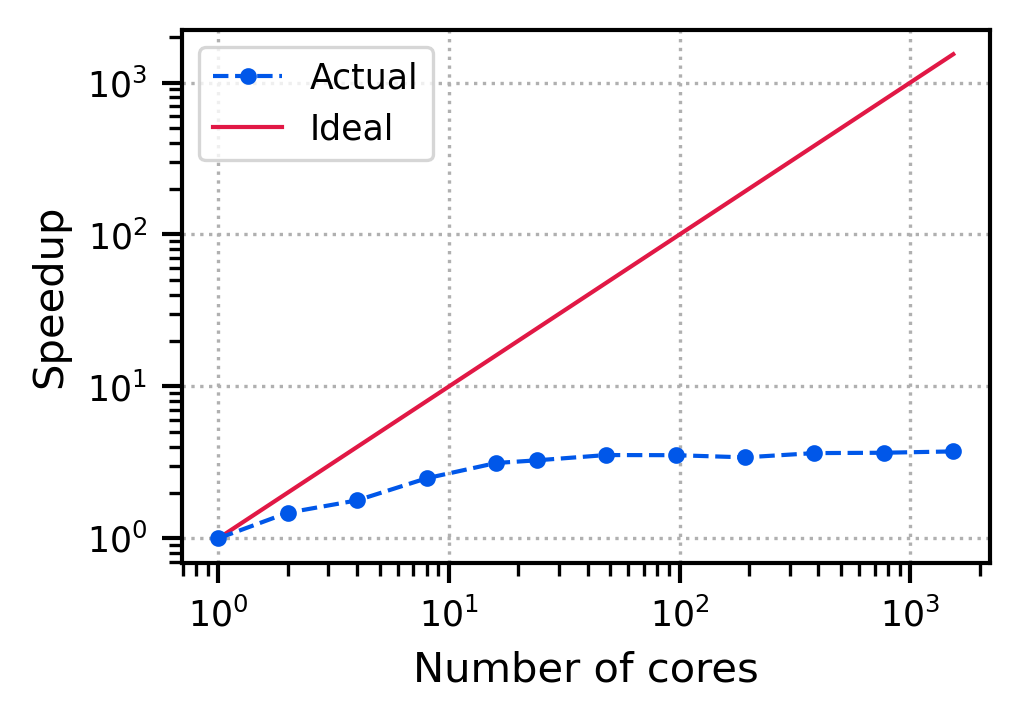

In [50]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
# SS_EX_DF.plot(x='ncpu', y='speedup', kind='line', ax=ax, figsize=figSize, title='Strong Scaling Exact Surface Speedup', grid=False, legend=True, style='o-', 
#               loglog=True, xlabel='Number of CPUs', ylabel='Speedup', fontsize=labelSize, colormap='Set1')
ax.plot(SS_EX_DF['ncpu'], SS_EX_DF['speedup'], 
        linewidth=lineWidth, linestyle='--', marker='o', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(SS_EX_DF['ncpu'], SS_EX_DF['ncpu'], 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, color=hexCodes[0], zorder=2)  # Amdahl's Law
ax.loglog()
ax.set_xlabel('Number of cores', fontsize='medium')
ax.set_ylabel('Speedup', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
# ax.set_title('Strong Scaling Exact Surface Speedups')
ax.legend(labels=('Actual', 'Ideal'), fontsize='small')
plt.tight_layout()
plt.savefig('SS_EX_Speedups.png')

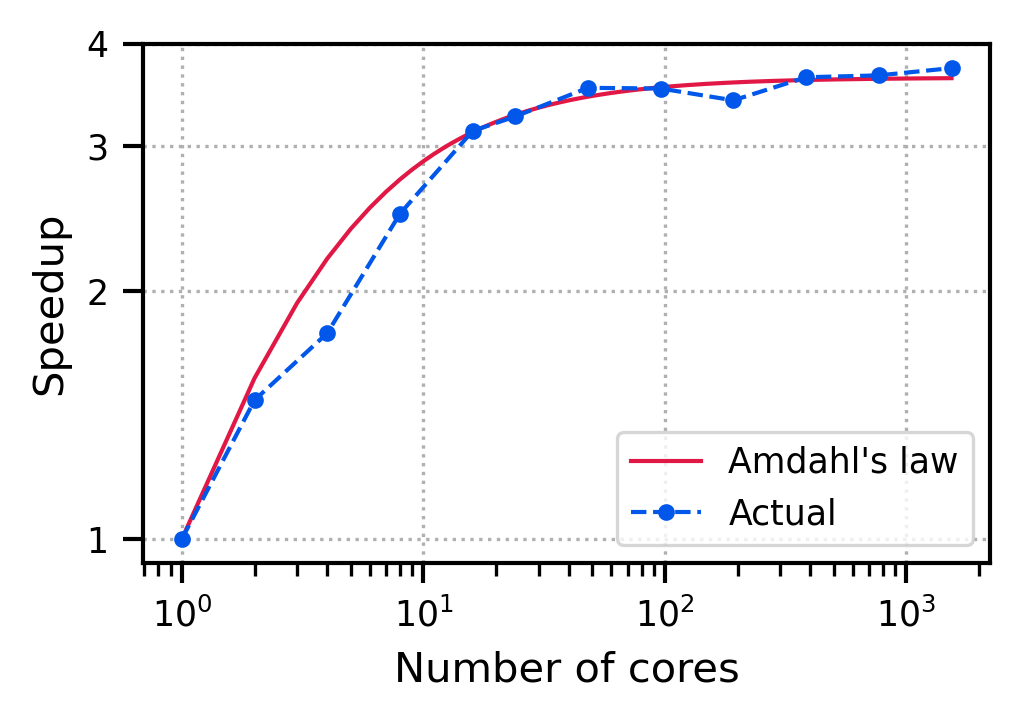

In [51]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)

# Amdahl's law
p = 0.725
s = np.array(range(1, SS_Ncpus[-1]+1))
amdahl = 1 / ((1-p) + p/s)
ax.plot(s, amdahl, 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, color=hexCodes[0], zorder=2)

ax.plot(SS_EX_DF['ncpu'], SS_EX_DF['speedup'], 
        linewidth=lineWidth, linestyle='--', marker='o', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.loglog()
ax.set_xlabel('Number of cores', fontsize='medium')
ax.set_ylabel('Speedup', fontsize='medium')
ax.set_yticks([1.0, 2.0, 3.0, 4.0])
ax.tick_params(axis='both', labelsize='small')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.grid(linestyle='dotted')
ax.legend(labels=("Amdahl's law", 'Actual'), fontsize='small')
# ax.set_title('Strong Scaling Exact Surface Actual Speedup')
plt.tight_layout()
plt.savefig('SS_EX_Speedup.png')

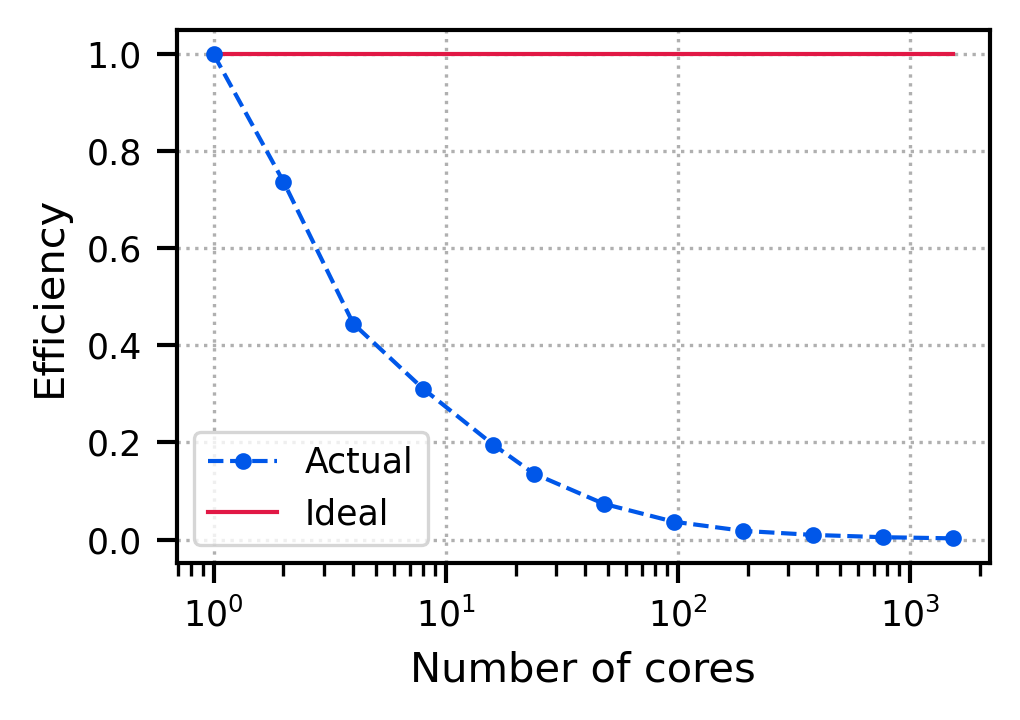

In [52]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
# strongScalingDF.plot(x='ncpu', y='speedup', kind='line', ax=ax, figsize=figSize, title='Strong Scaling Speedup', grid=False, legend=True, style='o-', 
                     # loglog=True, xlabel='Number of CPUs', ylabel='Speedup', fontsize=labelSize, colormap='Set1')
ax.plot(SS_EX_DF['ncpu'], SS_EX_DF['efficiency'], 
        linewidth=lineWidth, linestyle='--', marker='o', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(SS_EX_DF['ncpu'], [1] * len(SS_EX_DF['ncpu']), 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, color=hexCodes[0], zorder=2)
plt.xscale('log')
ax.set_xlabel('Number of cores', fontsize='medium')
ax.set_ylabel('Efficiency', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Actual', 'Ideal'), fontsize='small')
# ax.set_title('Strong Scaling Exact Surface Efficiency')
plt.tight_layout()
plt.savefig('SS_EX_Efficiency.png')

### Weak Scaling

To calculate weak scaling parallelisation efficiency, the number of processors and the problem size are both increased, to maintain a constant workload per processor. 

Note that it was difficult to maintain a constant workload exactly in our case as the nanoparticles are generated based on diameters instead of number of atoms. The test cases were chosen based on the closest number of atoms to the ideal setup.

In [53]:
WS_Ncpus = (1, 2, 4, 8, 16, 24, 48, 96, 192, 384, 768, 1536)
WS_Nnodes = (1, 1, 1, 1, 1, 1, 1, 2, 4, 8, 16, 32)
WS_NumAtomsIdeal = (43, 86, 172, 344, 688, 1032, 2064, 4128, 8256, 16512, 33024, 66048)
WS_NumAtoms = (43, 87, 177, 321, 683, 1055, 1961, 4189, 8007, 16187, 33573, 66283)
WS_Diameters = (10, 14, 17, 20, 27, 31, 38, 49, 61, 77, 98, 123)  # Angstroms
# for i in zip(WS_Ncpus, WS_Diameters): print(i)

#### Voxelised Point Cloud Surface Representation

In [54]:
WS_VX_AllDurations = getAllDurations('runtimes/weakScaling', 'vx')
WS_VX_DurationsDF = pd.DataFrame(np.array(WS_VX_AllDurations).T, columns=WS_Ncpus) 
WS_VX_DurationsDF.head()

vx1
vx2
vx4
vx8
vx16
vx24
vx48
vx96
vx192
vx384
vx768
vx1536


,1,2,4,8,16,24,48,96,192,384,768,1536
0,3.8835,4.4829,4.4076,4.7179,4.6638,4.8579,5.6211,9.2367,21.7067,72.0234,284.8746,1327.8444
1,3.8553,4.3428,4.3674,4.5514,4.5102,4.7828,5.6303,9.3221,21.5630,71.5973,286.7627,1459.3765
2,3.9378,4.3299,4.4223,4.4709,4.4719,4.8010,5.8207,9.4334,21.4303,71.2096,283.6056,1386.6781
3,3.8705,4.4200,4.3293,4.6570,4.8252,4.7212,5.6172,9.1593,21.3873,71.8193,280.8103,1385.3561
4,3.8828,4.4812,4.3485,4.4427,4.6003,4.7137,5.6327,9.1588,21.6824,71.5363,284.5705,1375.5509


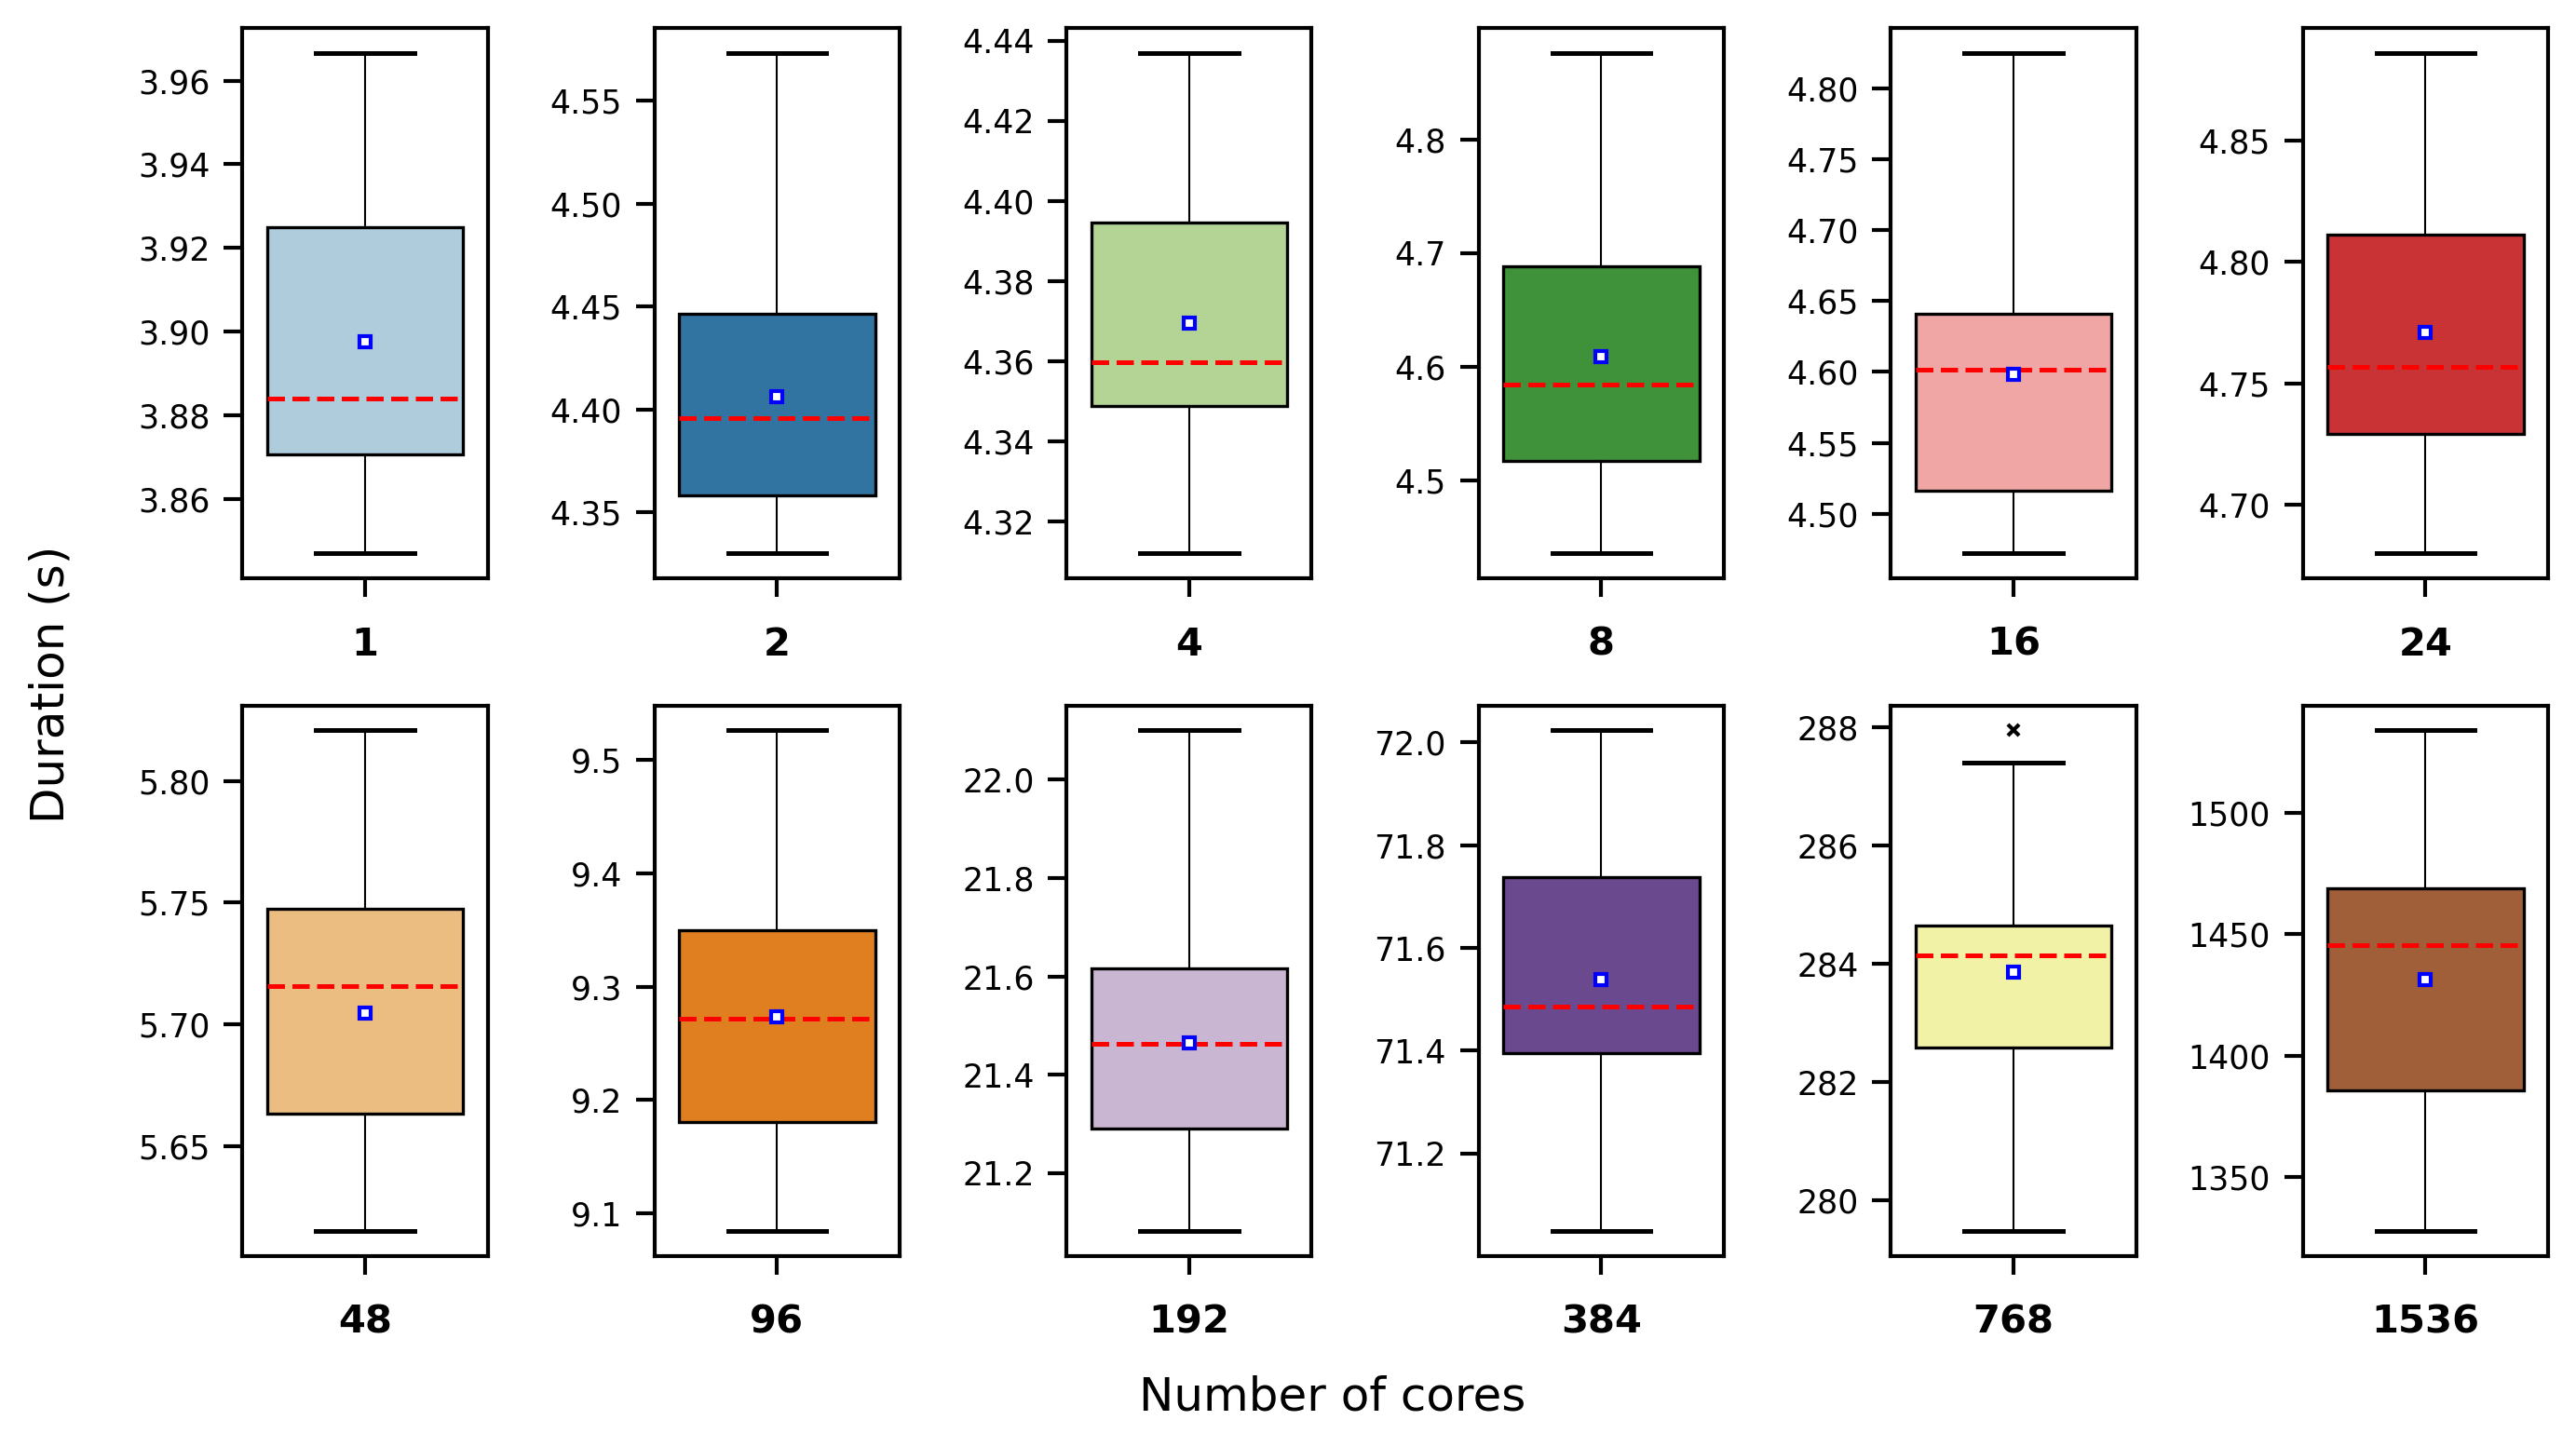

In [55]:
initBoxPlots(WS_VX_DurationsDF, 'Number of cores', 'VX', 'WS', '')

In [56]:
WS_VX_Durations = rmOutliers(WS_VX_DurationsDF, 'cpu')

1 cpu(s)	: Retained 30 out of 30 samples
2 cpu(s)	: Retained 30 out of 30 samples
4 cpu(s)	: Retained 30 out of 30 samples
8 cpu(s)	: Retained 30 out of 30 samples
16 cpu(s)	: Retained 30 out of 30 samples
24 cpu(s)	: Retained 30 out of 30 samples
48 cpu(s)	: Retained 30 out of 30 samples
96 cpu(s)	: Retained 30 out of 30 samples
192 cpu(s)	: Retained 30 out of 30 samples
384 cpu(s)	: Retained 30 out of 30 samples
768 cpu(s)	: Retained 30 out of 30 samples
1536 cpu(s)	: Retained 30 out of 30 samples


We can then compute the weak scaling efficiencies and plot them:

In [57]:
WS_VX_DF = pd.DataFrame({'ncpu':WS_Ncpus, 'duration': WS_VX_Durations}, columns=['ncpu', 'duration'])
WS_VX_DF['efficiency'] = WS_VX_DF['duration'][0] / WS_VX_DF['duration']
WS_VX_DF.head()

,ncpu,duration,efficiency
0,1,3.897463,1.000000
1,2,4.406287,0.884523
2,4,4.369523,0.891965
3,8,4.609260,0.845572
4,16,4.598523,0.847547


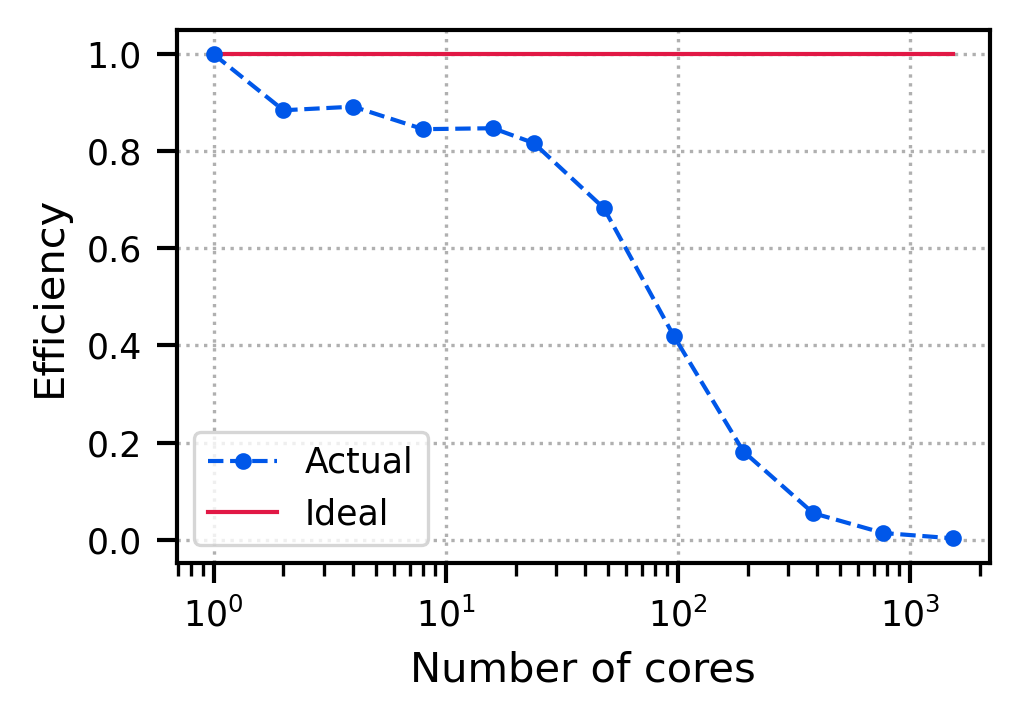

In [58]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(WS_VX_DF['ncpu'], WS_VX_DF['efficiency'], 
        linewidth=lineWidth, linestyle='--', marker='o', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(WS_VX_DF['ncpu'], [1] * len(WS_VX_DF['ncpu']), 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, color=hexCodes[0], zorder=2)
plt.xscale('log')
ax.set_xlabel('Number of cores', fontsize='medium')
ax.set_ylabel('Efficiency', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Actual', 'Ideal'), fontsize='small')
# ax.set_title('Weak Scaling Voxelised Surface Efficiency')
plt.tight_layout()
plt.savefig('WS_VX_Efficiency.png')

#### Mathematically Exact Surface Representation

Here are the results collected:

In [59]:
WS_EX_AllDurations = getAllDurations('runtimes/weakScaling', 'ex')
WS_EX_DurationsDF = pd.DataFrame(np.array(WS_EX_AllDurations).T, columns=WS_Ncpus) 
WS_EX_DurationsDF.head()

ex1
ex2
ex4
ex8
ex16
ex24
ex48
ex96
ex192
ex384
ex768
ex1536


,1,2,4,8,16,24,48,96,192,384,768,1536
0,1.8741,1.7156,3.2403,3.3059,4.0972,6.5918,6.5454,11.1276,23.6390,75.2461,296.1889,1265.1279
1,1.7393,1.6498,2.9941,3.1955,3.9667,6.5288,6.4389,11.4324,23.8917,74.1170,297.9117,1299.9348
2,1.7447,1.6796,3.2295,3.3675,4.0735,6.4743,6.6585,11.1885,23.7890,74.4456,294.9023,1263.6373
3,1.7501,1.6429,3.2776,3.3165,4.3008,6.5515,6.4927,11.2468,23.8023,75.5381,295.3659,1266.7945
4,1.8782,1.7735,3.1622,3.3675,4.1254,6.4777,6.7909,11.5643,23.7964,74.3699,298.6450,1289.1267


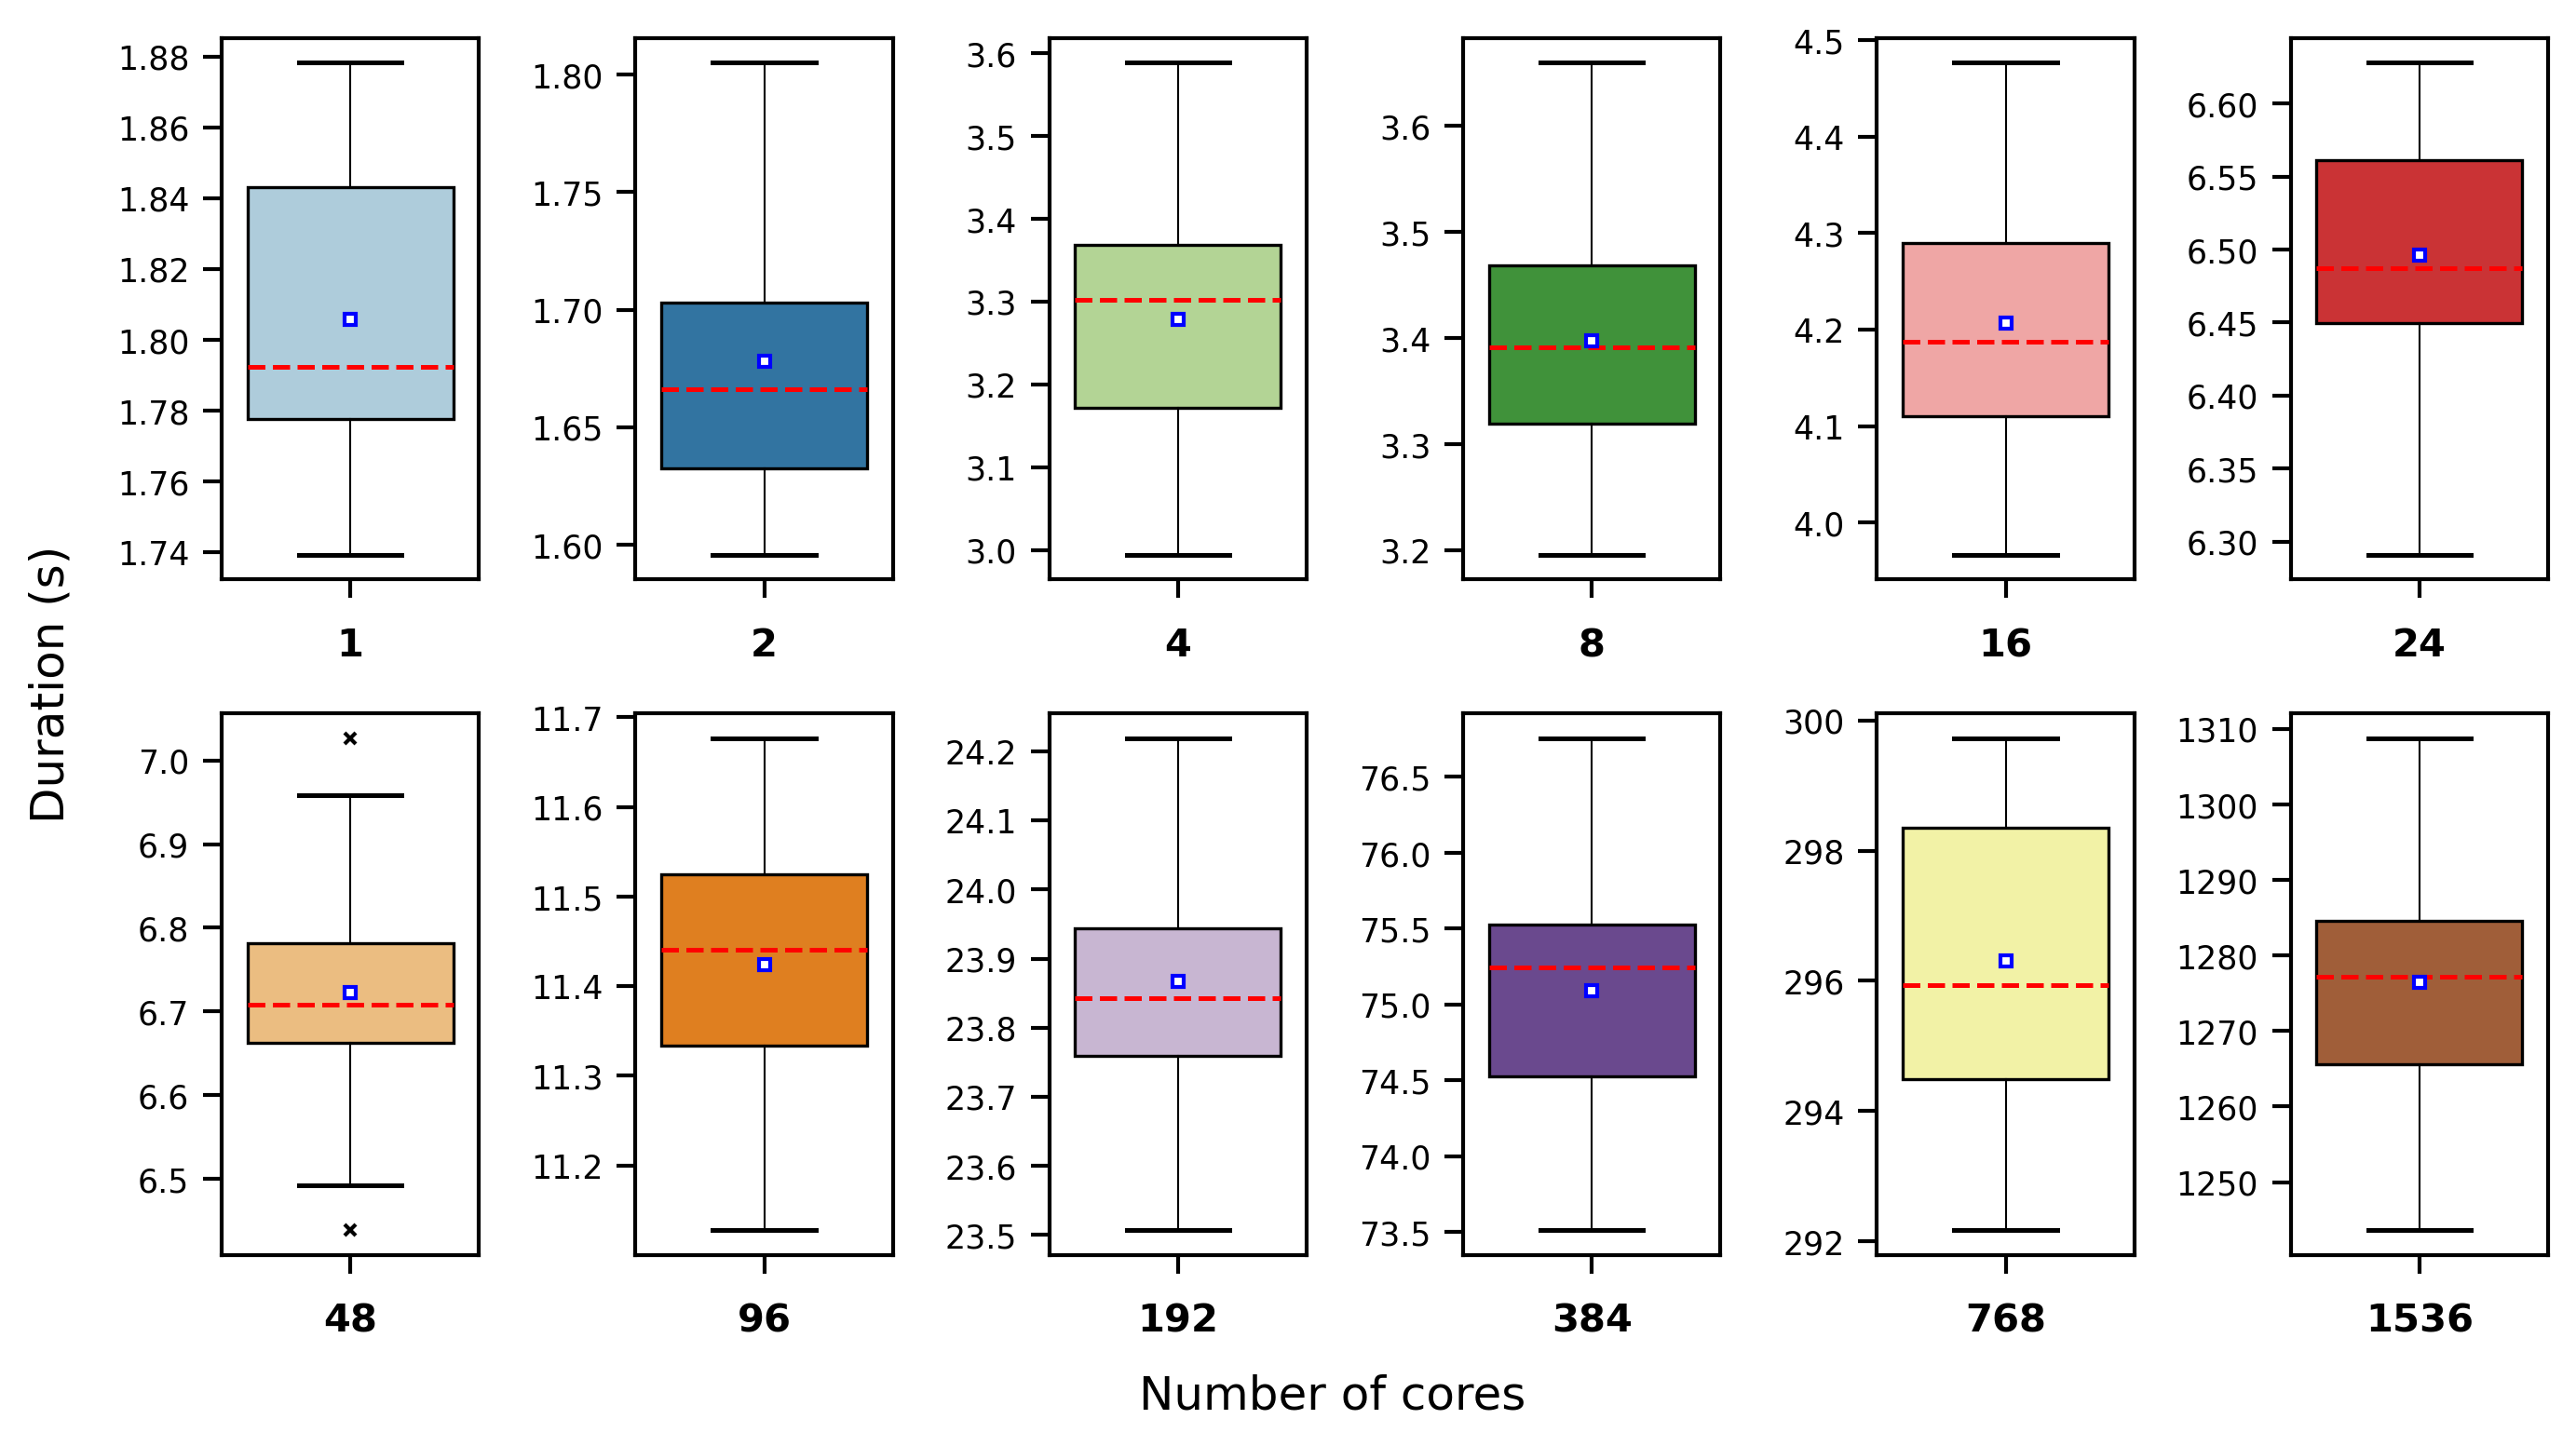

In [60]:
initBoxPlots(WS_EX_DurationsDF, 'Number of cores', 'EX', 'WS', '')

In [61]:
WS_EX_Durations = rmOutliers(WS_EX_DurationsDF, 'cpu')

1 cpu(s)	: Retained 30 out of 30 samples
2 cpu(s)	: Retained 30 out of 30 samples
4 cpu(s)	: Retained 30 out of 30 samples
8 cpu(s)	: Retained 30 out of 30 samples
16 cpu(s)	: Retained 30 out of 30 samples
24 cpu(s)	: Retained 30 out of 30 samples
48 cpu(s)	: Retained 30 out of 30 samples
96 cpu(s)	: Retained 30 out of 30 samples
192 cpu(s)	: Retained 30 out of 30 samples
384 cpu(s)	: Retained 30 out of 30 samples
768 cpu(s)	: Retained 30 out of 30 samples
1536 cpu(s)	: Retained 30 out of 30 samples


We can then compute the weak scaling efficiencies and plot them:

In [62]:
WS_EX_DF = pd.DataFrame({'ncpu':WS_Ncpus, 'duration': WS_EX_Durations}, columns=['ncpu', 'duration'])
WS_EX_DF['efficiency'] = WS_EX_DF['duration'][0] / WS_EX_DF['duration']
WS_EX_DF.head()

,ncpu,duration,efficiency
0,1,1.805840,1.000000
1,2,1.678077,1.076137
2,4,3.278620,0.550793
3,8,3.397573,0.531509
4,16,4.207037,0.429243


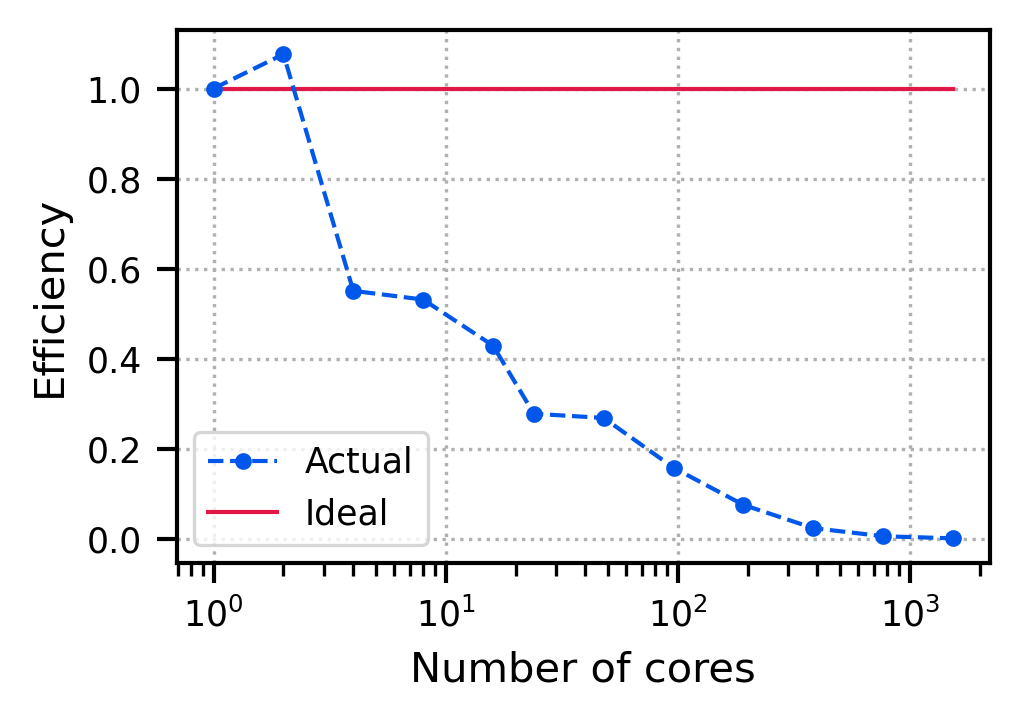

In [63]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(WS_EX_DF['ncpu'], WS_EX_DF['efficiency'], 
        linewidth=lineWidth, linestyle='--', marker='o', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(WS_EX_DF['ncpu'], [1] * len(WS_EX_DF['ncpu']), 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, color=hexCodes[0], zorder=2)
plt.xscale('log')
ax.set_xlabel('Number of cores', fontsize='medium')
ax.set_ylabel('Efficiency', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Actual', 'Ideal'), fontsize='small')
# ax.set_title('Weak Scaling Exact Surface Efficiency')
plt.tight_layout()
plt.savefig('WS_EX_Efficiency.png')